# Proyek Analisis Sentimen

 Notebook ini berisi analisis sentimen berdasarkan data ulasan dari aplikasi Brimo.

##

# Import Libraries  

Pada bagian ini, kita mengimpor pustaka (libraries) utama yang akan digunakan dalam analisis data, seperti pandas untuk pengolahan data, numpy untuk operasi numerik, serta matplotlib dan seaborn untuk visualisasi data.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##

# TQDM

TQDM digunakan untuk memberikan progress bar yang berguna ketika menjalankan operasi yang memerlukan waktu lama, sehingga pengguna dapat melihat progres pengerjaan secara real time.

In [6]:
%pip install tqdm

from tqdm import tqdm
tqdm.pandas()  # Integrasi tqdm dengan pandas

# Membaca Data Ulasan

Data ulasan diimpor dari file CSV yang telah dihasilkan dari proses scraping. Fungsi DF digunakan untuk menampilkan data baris awal guna memastikan data sudah terbaca dengan benar. Dan sesuai dengan kriteria Memiliki jumlah data minimal 10.000 sampel data

In [8]:
# Menentukan path file CSV hasil scraping
file_path = r'D:\PROJECT\Proyek Analisis Sentimen\Dataset\ulasan_apk_brimo.csv'

# Membaca file CSV ke dalam DataFrame
df = pd.read_csv(file_path)

# Menampilkan DataFrame sebagai tabel
df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,000653b0-6359-4cae-8121-1412fcd19928,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,mantap,5,0,2.80.0,2025-03-20 14:38:38,NaN,NaN,2.80.0
1,e5fb920c-a899-43d9-b60e-4e6e04ccc03c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"heran sama brimo, no TLP masih aktif dan di pa...",5,0,2.80.0,2025-03-20 14:38:17,"Hai Sobat BRI, mohon maaf atas ketidaknyamanan...",2025-03-21 10:05:52,2.80.0
2,13768031-6a3a-4dde-a991-a9343dc54e2e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat membantu,4,0,2.80.0,2025-03-20 14:37:29,NaN,NaN,2.80.0
3,e23de61d-8ace-4be2-8f72-313507fa6431,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat sangat mmbantu,5,0,2.80.0,2025-03-20 14:33:15,NaN,NaN,2.80.0
4,8fe84d8b-318a-469a-b65a-356ca59c2d49,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"udah di update ngikutin perintah, malah aplika...",1,0,2.80.0,2025-03-20 14:30:11,"Hai Sobat BRI, mohon maaf atas ketidaknyamanan...",2025-03-21 10:03:18,2.80.0
...,...,...,...,...,...,...,...,...,...,...,...
59995,19bc3694-1192-4550-8208-517aa5318e95,Zainal Ilmi,https://play-lh.googleusercontent.com/a/ACg8oc...,Mantap,1,0,2.48.0,2024-10-30 00:46:10,"Hai, Sobat BRI. Terima kasih atas ulasannya. S...",2024-10-30 15:14:24,2.48.0
59996,b86c1bfb-70c2-4915-8587-3a50beb8f3c1,Julius Rianto,https://play-lh.googleusercontent.com/a-/ALV-U...,"Tolong pembaharuan APK brimo, simulasi pinjama...",5,0,2.71.1,2024-10-30 00:28:59,"Hai, Sobat BRI. Mohon maaf atas kendala yang d...",2024-11-02 15:25:51,2.71.1
59997,94bdbd29-b50a-42c2-9697-4d46a52f6cf9,igor irfanov,https://play-lh.googleusercontent.com/a-/ALV-U...,Semua transaksi lebih mudah dengan BRImo,5,0,2.70.0,2024-10-30 00:23:39,"Hai, Sobat BRI. Terima kasih atas ulasannya. S...",2024-10-30 01:39:43,2.70.0
59998,84bb7bab-ce00-4391-b437-b347ad68d91f,Sahlan Pa,https://play-lh.googleusercontent.com/a-/ALV-U...,Good luck transaksi lebih gampang,5,0,2.71.1,2024-10-30 00:20:07,"Hai, Sobat BRI. Terima kasih atas ulasannya. S...",2024-10-30 01:39:42,2.71.1


# Mengecek Missing Data

Kita menghitung jumlah nilai yang hilang (NaN) di tiap kolom untuk mengetahui apakah ada kolom yang perlu penanganan khusus (misal, imputasi atau penghapusan).

In [9]:
# Menghitung dan menampilkan nilai NaN
missing_data = df.isna().sum()  # Menampilkan jumlah NaN per kolom
print(missing_data)

reviewId                    0
userName                    0
userImage                   0
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion    10639
at                          0
replyContent              354
repliedAt                 354
appVersion              10639
dtype: int64


# Menghapus Nilai NaN
Setelah mengecek missing data, langkah selanjutnya adalah menghapus baris-baris yang memiliki nilai NaN agar analisis data tidak terpengaruh oleh data yang tidak lengkap.

In [10]:
# Menghapus baris yang memiliki nilai NaN pada seluruh kolom
df.dropna(inplace=True)

# Cek kembali untuk memastikan tidak ada nilai NaN yang tersisa
print(df.isna().sum())

reviewId                0
userName                0
userImage               0
content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
replyContent            0
repliedAt               0
appVersion              0
dtype: int64


Pada cell di atas, fungsi dropna() digunakan untuk menghapus semua baris yang memiliki nilai NaN. Hal ini memastikan bahwa dataset yang digunakan untuk analisis sentimen bersih dari data yang tidak lengkap, sehingga dapat meningkatkan kualitas dan keakuratan model yang akan dikembangkan.

##

# Ringkasan DataFrame

Fungsi info() memberikan ringkasan dari DataFrame, termasuk jumlah data, tipe data per kolom, dan penggunaan memori. Ini membantu dalam memahami struktur data sebelum diproses lebih lanjut.

In [11]:
# Tampilkan ringkasan dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49066 entries, 1 to 59999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              49066 non-null  object
 1   userName              49066 non-null  object
 2   userImage             49066 non-null  object
 3   content               49066 non-null  object
 4   score                 49066 non-null  int64 
 5   thumbsUpCount         49066 non-null  int64 
 6   reviewCreatedVersion  49066 non-null  object
 7   at                    49066 non-null  object
 8   replyContent          49066 non-null  object
 9   repliedAt             49066 non-null  object
 10  appVersion            49066 non-null  object
dtypes: int64(2), object(9)
memory usage: 4.5+ MB


##

# Penghapusan Kolom yang Tidak Diperlukan

Kolom-kolom yang dianggap tidak relevan untuk analisis sentimen dihapus agar dataset lebih bersih dan memudahkan pemrosesan data.

In [12]:
# Hapus kolom pada DataFrame
df = df.drop(columns=['reviewId', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'replyContent',
                      'repliedAt', 'appVersion'])
print(df.columns)


Index(['userName', 'content', 'score', 'at'], dtype='object')


### Menampilkan DataFrame yang Sudah Dibersihkan

In [13]:
# Tampilkan Dataframe
df.head()

,userName,content,score,at
1,Pengguna Google,"heran sama brimo, no TLP masih aktif dan di pa...",5,2025-03-20 14:38:17
4,Pengguna Google,"udah di update ngikutin perintah, malah aplika...",1,2025-03-20 14:30:11
8,Pengguna Google,Knp brimo ku ga bisa D buka Ya Mohon penceraha...,4,2025-03-20 14:21:29
9,Pengguna Google,terbaikkk,5,2025-03-20 14:20:21
10,Pengguna Google,good app,5,2025-03-20 14:14:51


### Informasi DataFrame Setelah Penghapusan Kolom

Memanggil kembali info() untuk memastikan struktur DataFrame dan mengetahui bahwa hanya kolom-kolom yang dibutuhkan (userName, content, score, at) yang tersisa.

In [14]:
# Tampilkan ringkasan informasi
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49066 entries, 1 to 59999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  49066 non-null  object
 1   content   49066 non-null  object
 2   score     49066 non-null  int64 
 3   at        49066 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


##

# Analisis Distribusi Nilai Score

Kode ini menghitung dan menampilkan distribusi nilai score dari ulasan, kemudian divisualisasikan dengan bar plot untuk memudahkan pemahaman persebaran rating ulasan.

score
5    37779
1     5168
4     3141
3     1621
2     1357
Name: count, dtype: int64


C:\Users\Sion Pardosi\AppData\Local\Temp\ipykernel_38148\2771258360.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=score_counts.index, y=score_counts.values, palette="viridis")


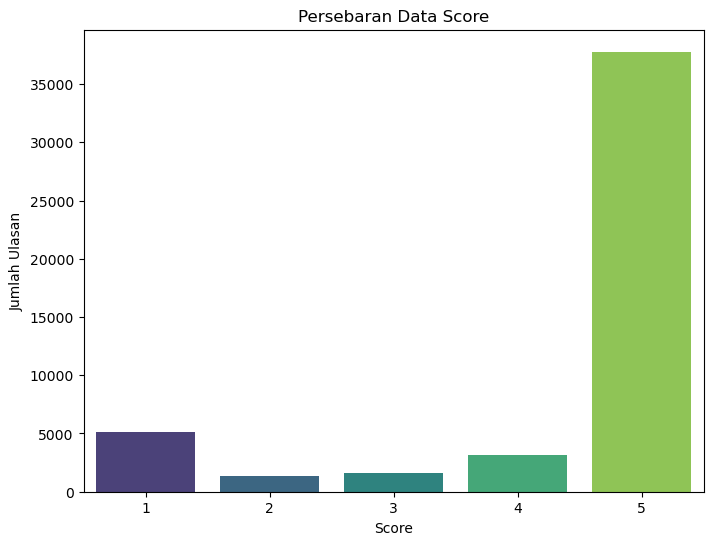

In [15]:
# Menghitung frekuensi setiap nilai score (1-5)
score_counts = df['score'].value_counts()
print(score_counts)

# Visualisasi distribusi score menggunakan bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=score_counts.index, y=score_counts.values, palette="viridis")
plt.title('Persebaran Data Score')
plt.xlabel('Score')
plt.ylabel('Jumlah Ulasan')
plt.show()

##

# Preprocessing Data: Menghapus Duplikat

Duplikat dihapus dengan basis kolom 'content' untuk memastikan bahwa setiap ulasan dihitung satu kali. Hal ini penting agar analisis tidak bias akibat data yang berulang.

In [16]:
# Menghapus duplikat berdasarkan kolom 'content' agar setiap ulasan unik
df.drop_duplicates(subset='content', keep='first', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31139 entries, 1 to 59999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  31139 non-null  object
 1   content   31139 non-null  object
 2   score     31139 non-null  int64 
 3   at        31139 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


##

# WordCloud Sebelum Preprocessing

WordCloud dibuat untuk memvisualisasikan kata-kata yang sering muncul dalam ulasan sebelum dilakukan preprocessing lebih lanjut. Ini membantu mengidentifikasi kata-kata umum dan potensi noise dalam data.

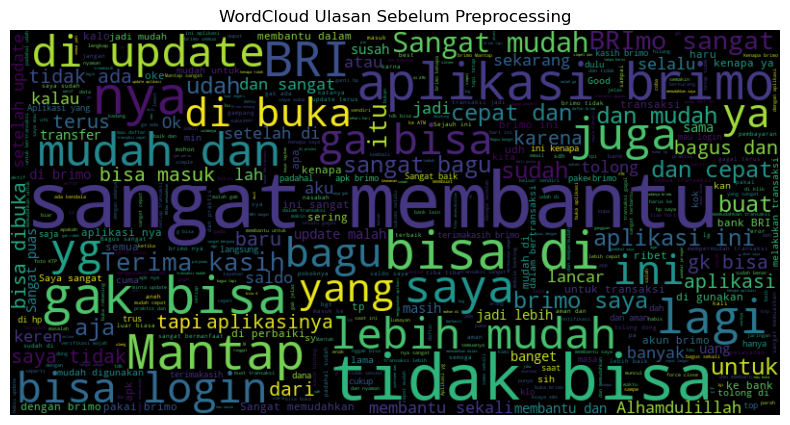

In [17]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Pastikan tidak ada nilai NaN pada kolom 'content'
df['content'] = df['content'].fillna('')

# Menggabungkan semua teks ulasan
text = ' '.join(df['content'].astype(str).tolist())

# Menentukan stopwords tambahan
stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'RT', '...', 'amp'])

# Membuat objek WordCloud
wc = WordCloud(stopwords=stopwords, background_color="black", max_words=500, width=800, height=400)
wc.generate(text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud Ulasan Sebelum Preprocessing")
plt.show()

##

# Visualisasi Frekuensi Kata

Visualisasi frekuensi kata ini memperlihatkan 10 kata paling umum dari ulasan. Dengan menggunakan bar plot, kita dapat dengan mudah melihat distribusi kata-kata yang dominan sebelum data diproses lebih lanjut dalam analisis sentimen.

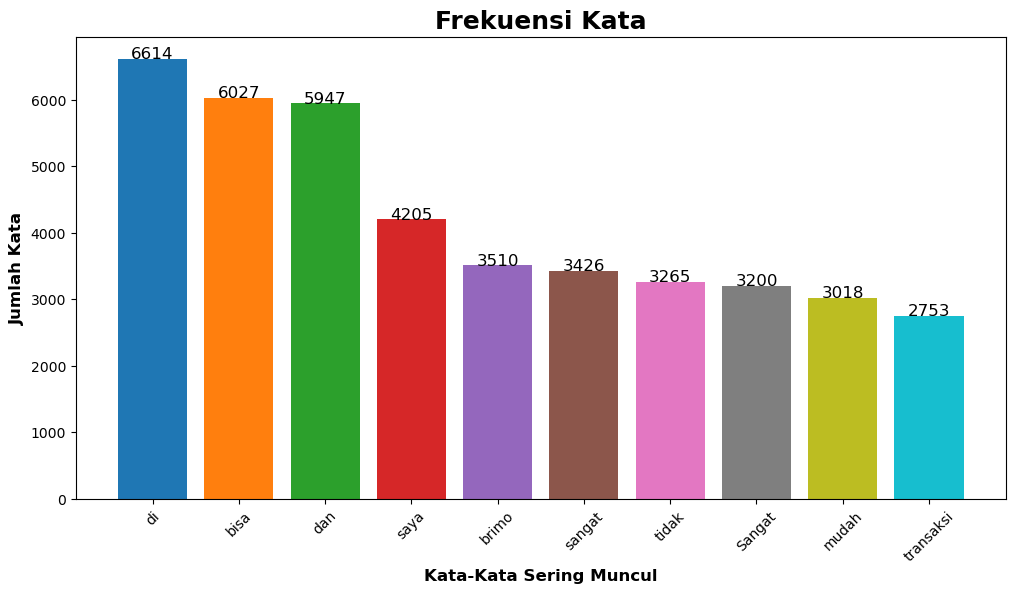

In [18]:
import matplotlib.pyplot as plt
from collections import Counter

# Menggabungkan seluruh teks dari kolom 'content'
text = " ".join(df["content"].astype(str))

# Tokenisasi teks berdasarkan spasi
tokens = text.split()

# Menghitung frekuensi setiap kata
word_counts = Counter(tokens)

# Mengambil 10 kata yang paling sering muncul
top_words = word_counts.most_common(10)

# Memisahkan kata dan jumlahnya
words, counts = zip(*top_words)

# Mendefinisikan palet warna
colors = plt.cm.tab10(range(len(words)))

# Membuat bar plot untuk frekuensi kata
plt.figure(figsize=(12, 6))
bars = plt.bar(words, counts, color=colors)
plt.xlabel("Kata-Kata Sering Muncul", fontsize=12, fontweight='bold')
plt.ylabel("Jumlah Kata", fontsize=12, fontweight='bold')
plt.title("Frekuensi Kata", fontsize=18, fontweight='bold')
plt.xticks(rotation=45)

# Menambahkan nilai di atas setiap bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 1, str(count), fontsize=12, color='black', ha='center')

plt.show()

##

# Inisialisasi Daftar Sentimen (Numeric Label)

Kode di atas membuat kolom label_num secara vectorized dengan memberikan label numerik berdasarkan skor ulasan: 1 untuk skor di atas 3 (positif), 0 untuk skor sama dengan 3 (netral), dan -1 untuk skor di bawah 3 (negatif).

In [19]:
# Inisialisasi daftar sentimen
label_num = []

# Iterasi setiap baris dalam DataFrame
for index, row in df.iterrows():
    if row['score'] > 3 :
        label_num.append(1)     # nilai 1 untuk score 4 - 5 
    elif row['score'] == 3:
        label_num.append(0)     # nilai 0 untuk score 3
    else:
        label_num.append(-1)    # nilai -1 untuk score 1 - 2
        
# Tambahkan kolom baru         
df['label_num'] = label_num
df


,userName,content,score,at,label_num
1,Pengguna Google,"heran sama brimo, no TLP masih aktif dan di pa...",5,2025-03-20 14:38:17,1
4,Pengguna Google,"udah di update ngikutin perintah, malah aplika...",1,2025-03-20 14:30:11,-1
8,Pengguna Google,Knp brimo ku ga bisa D buka Ya Mohon penceraha...,4,2025-03-20 14:21:29,1
9,Pengguna Google,terbaikkk,5,2025-03-20 14:20:21,1
10,Pengguna Google,good app,5,2025-03-20 14:14:51,1
...,...,...,...,...,...
59993,Leonora Desi,Sangat puas dan bagus pake brimo,5,2024-10-30 01:10:07,1
59996,Julius Rianto,"Tolong pembaharuan APK brimo, simulasi pinjama...",5,2024-10-30 00:28:59,1
59997,igor irfanov,Semua transaksi lebih mudah dengan BRImo,5,2024-10-30 00:23:39,1
59998,Sahlan Pa,Good luck transaksi lebih gampang,5,2024-10-30 00:20:07,1


##

# Pelabelan (Teks Label)

Di sini, kolom label diisi dengan label teks berdasarkan skor ulasan. Metode vectorized memudahkan proses pelabelan dengan hasil yang konsisten untuk setiap baris data.

In [20]:
# Inisialisasi daftar label
label = []

# Iterasi setiap baris dalam DataFrame
for index, row in df.iterrows():
    if row['score'] > 3 :
        label.append("positive")     # nilai 1 untuk score 4 - 5 
    elif row['score'] == 3:
        label.append("neutral")     # nilai 0 untuk score 3
    else:
        label.append("negative")    # nilai -1 untuk score 1 - 2
        
# Tambahkan kolom baru         
df['label'] = label
df

,userName,content,score,at,label_num,label
1,Pengguna Google,"heran sama brimo, no TLP masih aktif dan di pa...",5,2025-03-20 14:38:17,1,positive
4,Pengguna Google,"udah di update ngikutin perintah, malah aplika...",1,2025-03-20 14:30:11,-1,negative
8,Pengguna Google,Knp brimo ku ga bisa D buka Ya Mohon penceraha...,4,2025-03-20 14:21:29,1,positive
9,Pengguna Google,terbaikkk,5,2025-03-20 14:20:21,1,positive
10,Pengguna Google,good app,5,2025-03-20 14:14:51,1,positive
...,...,...,...,...,...,...
59993,Leonora Desi,Sangat puas dan bagus pake brimo,5,2024-10-30 01:10:07,1,positive
59996,Julius Rianto,"Tolong pembaharuan APK brimo, simulasi pinjama...",5,2024-10-30 00:28:59,1,positive
59997,igor irfanov,Semua transaksi lebih mudah dengan BRImo,5,2024-10-30 00:23:39,1,positive
59998,Sahlan Pa,Good luck transaksi lebih gampang,5,2024-10-30 00:20:07,1,positive


##

# Visualisasi Distribusi Label Sentimen

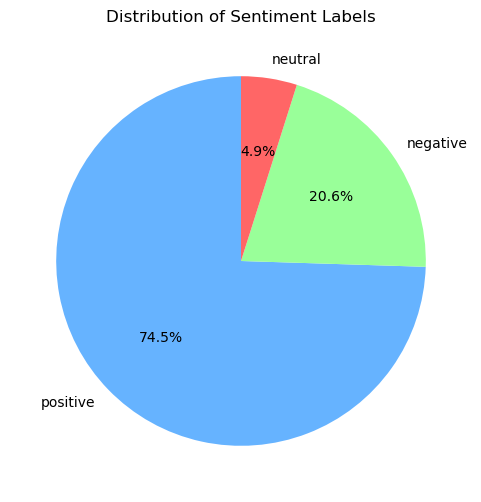

In [21]:
import matplotlib.pyplot as plt

# Menghitung jumlah masing-masing label
label_counts = df['label'].value_counts()

# Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90,
        colors=['#66b3ff', '#99ff99', '#ff6666'])
plt.title('Distribution of Sentiment Labels')
plt.show()

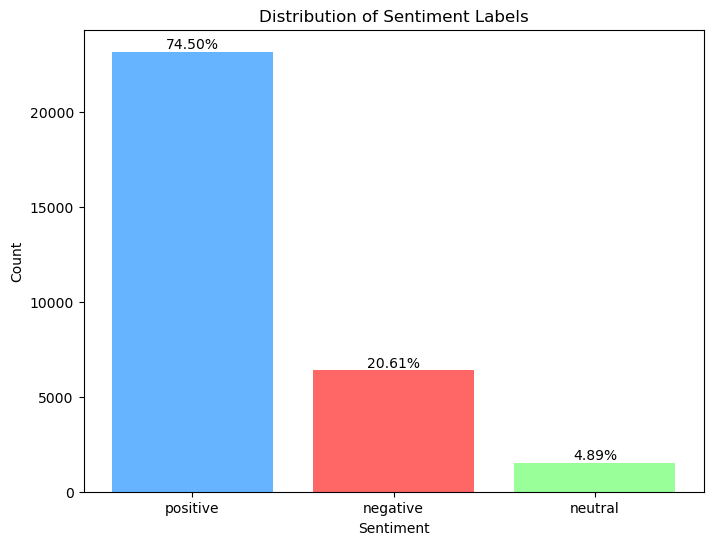

In [22]:
# Bar Chart
plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=['#66b3ff', '#ff6666', '#99ff99'])

# Menghitung persentase tiap label
label_percentages = label_counts / label_counts.sum() * 100

# Menambahkan persentase di atas tiap bar
for bar, percentage in zip(bars, label_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{percentage:.2f}%',
             ha='center', va='bottom')
    
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels')
plt.show()

**Insight:**

Dua jenis visualisasi (pie chart dan bar chart) digunakan untuk menggambarkan distribusi label sentimen. Hal ini penting untuk mengetahui proporsi masing-masing kategori sentimen dalam dataset.


##

# PREPROCESS TEXT: Pembersihan Teks

##

# NLTK

Instalasi library NLTK diperlukan untuk melakukan preprocessing teks, seperti tokenisasi, stopwords, dan stemming jika diperlukan.

In [36]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.


Setelah menginstall NLTK, kita mengimpor modul-modul yang dibutuhkan serta mendownload resource seperti tokenizers, stopwords, dan wordnet untuk mendukung preprocessing teks.

In [23]:
import string
import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Sion
[nltk_data]     Pardosi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sion
[nltk_data]     Pardosi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sion
[nltk_data]     Pardosi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Definisi Fungsi Preprocessing Teks

In [24]:
def preprocess_text(text):
    """
    Membersihkan teks dengan menghapus URL, mengubah ke lowercase, menghapus mention dan hashtag,
    serta menghapus karakter spesial, tanda baca, dan angka.
    """
    # Hapus URL
    text = re.sub(r'https?\S+', ' ', text, flags=re.IGNORECASE)
    
    # Ubah ke huruf kecil
    text = text.lower()
    
    # Hapus mention dan hashtag
    text = re.sub(r'[@#]\S+', ' ', text)
    
    # Hapus karakter spesial dan tanda baca menggunakan modul string
    text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), ' ', text)
    
    # Hapus angka (jika diperlukan)
    text = re.sub(r'\d+', ' ', text)
    
    # Hapus extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Terapkan Preprocessing ke Kolom Teks

Kolom content diisi ke dalam kolom baru text_Clean setelah melalui proses pembersihan. Proses ini penting untuk menyiapkan data ulasan sebelum dilakukan ekstraksi fitur dan pelatihan model analisis sentimen.

In [25]:
# Pastikan kolom 'content' tidak memiliki nilai NaN
df['content'] = df['content'].fillna('')

# Terapkan fungsi preprocess_text dengan integrasi progress bar dari tqdm
df['text_Clean'] = df['content'].progress_apply(preprocess_text)
df

100%|██████████| 31139/31139 [00:00<00:00, 65203.75it/s]


,userName,content,score,at,label_num,label,text_Clean
1,Pengguna Google,"heran sama brimo, no TLP masih aktif dan di pa...",5,2025-03-20 14:38:17,1,positive,heran sama brimo no tlp masih aktif dan di pas...
4,Pengguna Google,"udah di update ngikutin perintah, malah aplika...",1,2025-03-20 14:30:11,-1,negative,udah di update ngikutin perintah malah aplikas...
8,Pengguna Google,Knp brimo ku ga bisa D buka Ya Mohon penceraha...,4,2025-03-20 14:21:29,1,positive,knp brimo ku ga bisa d buka ya mohon penceraha...
9,Pengguna Google,terbaikkk,5,2025-03-20 14:20:21,1,positive,terbaikkk
10,Pengguna Google,good app,5,2025-03-20 14:14:51,1,positive,good app
...,...,...,...,...,...,...,...
59993,Leonora Desi,Sangat puas dan bagus pake brimo,5,2024-10-30 01:10:07,1,positive,sangat puas dan bagus pake brimo
59996,Julius Rianto,"Tolong pembaharuan APK brimo, simulasi pinjama...",5,2024-10-30 00:28:59,1,positive,tolong pembaharuan apk brimo simulasi pinjaman...
59997,igor irfanov,Semua transaksi lebih mudah dengan BRImo,5,2024-10-30 00:23:39,1,positive,semua transaksi lebih mudah dengan brimo
59998,Sahlan Pa,Good luck transaksi lebih gampang,5,2024-10-30 00:20:07,1,positive,good luck transaksi lebih gampang


# Membaca Kamus Slang

Pada bagian ini, kita membaca kamus slang dari file Excel dan menyusunnya menjadi dictionary. Fungsi ganti_slang akan mengganti setiap kata slang dalam teks dengan padanan kata bakunya.

In [26]:
# Membaca kamus slang dari file Excel
kamus_slang = pd.read_excel(r'D:\PROJECT\Proyek Analisis Sentimen\Dataset\kamuskatabaku.xlsx')

# Menyusun kamus slang sebagai dictionary: slang -> kata baku
slang_dict = dict(zip(kamus_slang['tidak_baku'], kamus_slang['kata_baku']))

# Fungsi untuk mengganti slang dengan kata baku
def ganti_slang(teks):
    return ' '.join([slang_dict.get(kata, kata) for kata in teks.split()])

# Contoh penerapan fungsi pada teks
print(ganti_slang("saya nggak tau, tapi sya ngerti"))


saya tidak tau, tapi saya mengerti


# Menerapkan Normalisasi Slang pada Data

Fungsi ganti_slang diterapkan ke kolom text_Clean (hasil preprocessing awal) untuk menghasilkan kolom baru text_Normalization yang berisi teks dengan kata-kata slang telah diganti ke bentuk baku.

In [27]:
# Menerapkan fungsi ganti_slang pada kolom 'text_StopWord'
df['text_Normalization'] = df['text_Clean'].progress_apply(ganti_slang)
df.head()

100%|██████████| 31139/31139 [00:00<00:00, 366672.18it/s]


,userName,content,score,at,label_num,label,text_Clean,text_Normalization
1,Pengguna Google,"heran sama brimo, no TLP masih aktif dan di pa...",5,2025-03-20 14:38:17,1,positive,heran sama brimo no tlp masih aktif dan di pas...,heran sama brimo no telepon masih aktif dan di...
4,Pengguna Google,"udah di update ngikutin perintah, malah aplika...",1,2025-03-20 14:30:11,-1,negative,udah di update ngikutin perintah malah aplikas...,sudah di update mengikuti perintah malah aplik...
8,Pengguna Google,Knp brimo ku ga bisa D buka Ya Mohon penceraha...,4,2025-03-20 14:21:29,1,positive,knp brimo ku ga bisa d buka ya mohon penceraha...,kenapa brimo ku tidak bisa di buka ya mohon pe...
9,Pengguna Google,terbaikkk,5,2025-03-20 14:20:21,1,positive,terbaikkk,terbaik
10,Pengguna Google,good app,5,2025-03-20 14:14:51,1,positive,good app,good app


# Mengunduh Stopwords dengan NLTK

Stopwords untuk bahasa Indonesia diunduh menggunakan NLTK, sehingga kita dapat menghapus kata-kata umum yang tidak memberikan nilai informasi pada analisis.

In [28]:
# Import pustaka nltk dari modul corpus dan download stopwords
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to C:\Users\Sion
[nltk_data]     Pardosi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Penghapusan Stopwords

Pada tahap ini, stopwords dihapus dari kolom text_Normalization. Hasilnya disimpan dalam kolom baru text_StopWord untuk meminimalisasi noise dan meningkatkan kualitas fitur teks.

In [29]:
# Hapus kata-kata umum (stopwords) menggunakan NLTK
stop = stopwords.words('indonesian')
df['text_StopWord'] = df['text_Normalization'].progress_apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop])
)
df.head()

100%|██████████| 31139/31139 [00:02<00:00, 13558.21it/s]


,userName,content,score,at,label_num,label,text_Clean,text_Normalization,text_StopWord
1,Pengguna Google,"heran sama brimo, no TLP masih aktif dan di pa...",5,2025-03-20 14:38:17,1,positive,heran sama brimo no tlp masih aktif dan di pas...,heran sama brimo no telepon masih aktif dan di...,heran brimo no telepon aktif pasang hp login n...
4,Pengguna Google,"udah di update ngikutin perintah, malah aplika...",1,2025-03-20 14:30:11,-1,negative,udah di update ngikutin perintah malah aplikas...,sudah di update mengikuti perintah malah aplik...,update mengikuti perintah aplikasi fc mulu tol...
8,Pengguna Google,Knp brimo ku ga bisa D buka Ya Mohon penceraha...,4,2025-03-20 14:21:29,1,positive,knp brimo ku ga bisa d buka ya mohon penceraha...,kenapa brimo ku tidak bisa di buka ya mohon pe...,brimo ku buka ya mohon pencerahan nyh
9,Pengguna Google,terbaikkk,5,2025-03-20 14:20:21,1,positive,terbaikkk,terbaik,terbaik
10,Pengguna Google,good app,5,2025-03-20 14:14:51,1,positive,good app,good app,good app


# Tokenisasi Teks dengan RegexpTokenizer / word_tokenize

Di sini kita menggunakan RegexpTokenizer dengan pola raw string (r'\w+') untuk melakukan tokenisasi pada teks. Hal ini memecah teks menjadi token berdasarkan karakter alfanumerik dan menghindari peringatan syntax terkait escape sequence.

In [30]:
# Mengimpor modul tokenisasi dan melakukan tokenisasi teks
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer

# Menggunakan raw string untuk pola regex agar tidak menghasilkan SyntaxWarning
regexp = RegexpTokenizer(r'\w+')

# Menerapkan tokenisasi pada kolom text_StopWord
df['text_Tokenization'] = df['text_StopWord'].progress_apply(regexp.tokenize)
df.head()

100%|██████████| 31139/31139 [00:00<00:00, 413537.89it/s]


,userName,content,score,at,label_num,label,text_Clean,text_Normalization,text_StopWord,text_Tokenization
1,Pengguna Google,"heran sama brimo, no TLP masih aktif dan di pa...",5,2025-03-20 14:38:17,1,positive,heran sama brimo no tlp masih aktif dan di pas...,heran sama brimo no telepon masih aktif dan di...,heran brimo no telepon aktif pasang hp login n...,"[heran, brimo, no, telepon, aktif, pasang, hp,..."
4,Pengguna Google,"udah di update ngikutin perintah, malah aplika...",1,2025-03-20 14:30:11,-1,negative,udah di update ngikutin perintah malah aplikas...,sudah di update mengikuti perintah malah aplik...,update mengikuti perintah aplikasi fc mulu tol...,"[update, mengikuti, perintah, aplikasi, fc, mu..."
8,Pengguna Google,Knp brimo ku ga bisa D buka Ya Mohon penceraha...,4,2025-03-20 14:21:29,1,positive,knp brimo ku ga bisa d buka ya mohon penceraha...,kenapa brimo ku tidak bisa di buka ya mohon pe...,brimo ku buka ya mohon pencerahan nyh,"[brimo, ku, buka, ya, mohon, pencerahan, nyh]"
9,Pengguna Google,terbaikkk,5,2025-03-20 14:20:21,1,positive,terbaikkk,terbaik,terbaik,[terbaik]
10,Pengguna Google,good app,5,2025-03-20 14:14:51,1,positive,good app,good app,good app,"[good, app]"


##

# Sastrawi

Baris kode ini menginstall package Sastrawi yang digunakan untuk proses stemming dalam bahasa Indonesia. Pastikan untuk me-restart kernel jika diperlukan setelah instalasi.

In [31]:
%pip install Sastrawi

Note: you may need to restart the kernel to use updated packages.


# Import dan Inisialisasi Sastrawi

Di sini, kita mengimpor modul Stemmer dari Sastrawi dan menginisialisasi stemmer dengan menggunakan StemmerFactory. Stemmer ini akan digunakan untuk mengubah kata ke bentuk dasarnya.

In [32]:
# import Sastrawi package
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Melakukan Stemming pada Token Teks

Kode ini menerapkan stemming pada setiap token yang dihasilkan dari tahap tokenisasi. Hasil stemming disimpan pada kolom baru text_Stemmindo sehingga setiap token diubah ke bentuk dasar (stem).

In [33]:
# Melakukan stemming dari tokens
df['text_Stemmindo'] = df['text_Tokenization'].progress_apply(lambda x: [stemmer.stem(y) for y in x])

  0%|          | 0/31139 [00:00<?, ?it/s]

100%|██████████| 31139/31139 [16:51<00:00, 30.79it/s] 


# Menampilkan Hasil DataFrame

Cell ini digunakan untuk menampilkan tampilan awal dari DataFrame sehingga dapat diverifikasi bahwa kolom text_Stemmindo telah terisi dengan token hasil stemming dari setiap baris data.

In [34]:
# Menampilkan beberapa baris pertama DataFrame untuk memastikan proses stemming telah berjalan dengan benar
df.head(20)

,userName,content,score,at,label_num,label,text_Clean,text_Normalization,text_StopWord,text_Tokenization,text_Stemmindo
1,Pengguna Google,"heran sama brimo, no TLP masih aktif dan di pa...",5,2025-03-20 14:38:17,1,positive,heran sama brimo no tlp masih aktif dan di pas...,heran sama brimo no telepon masih aktif dan di...,heran brimo no telepon aktif pasang hp login n...,"[heran, brimo, no, telepon, aktif, pasang, hp,...","[heran, brimo, no, telepon, aktif, pasang, hp,..."
4,Pengguna Google,"udah di update ngikutin perintah, malah aplika...",1,2025-03-20 14:30:11,-1,negative,udah di update ngikutin perintah malah aplikas...,sudah di update mengikuti perintah malah aplik...,update mengikuti perintah aplikasi fc mulu tol...,"[update, mengikuti, perintah, aplikasi, fc, mu...","[update, ikut, perintah, aplikasi, fc, mulu, t..."
8,Pengguna Google,Knp brimo ku ga bisa D buka Ya Mohon penceraha...,4,2025-03-20 14:21:29,1,positive,knp brimo ku ga bisa d buka ya mohon penceraha...,kenapa brimo ku tidak bisa di buka ya mohon pe...,brimo ku buka ya mohon pencerahan nyh,"[brimo, ku, buka, ya, mohon, pencerahan, nyh]","[brimo, ku, buka, ya, mohon, cerah, nyh]"
9,Pengguna Google,terbaikkk,5,2025-03-20 14:20:21,1,positive,terbaikkk,terbaik,terbaik,[terbaik],[baik]
10,Pengguna Google,good app,5,2025-03-20 14:14:51,1,positive,good app,good app,good app,"[good, app]","[good, app]"
16,Pengguna Google,"kenapa pake aplikasi Brimo, setiap selesai upd...",1,2025-03-20 14:07:54,-1,negative,kenapa pake aplikasi brimo setiap selesai upda...,kenapa pakai aplikasi brimo setiap selesai upd...,pakai aplikasi brimo selesai update masuk logi...,"[pakai, aplikasi, brimo, selesai, update, masu...","[pakai, aplikasi, brimo, selesai, update, masu..."
17,Pengguna Google,2 tahun yang lalu Pelayanan BRI ribet dan kura...,5,2025-03-20 14:05:13,1,positive,tahun yang lalu pelayanan bri ribet dan kurang...,tahun yang lalu pelayanan bri ribet dan kurang...,pelayanan bri ribet ramah alhamdulillah kemaju...,"[pelayanan, bri, ribet, ramah, alhamdulillah, ...","[layan, bri, ribet, ramah, alhamdulillah, maju..."
18,Pengguna Google,lebih mudah untuk transaksi,5,2025-03-20 14:05:05,1,positive,lebih mudah untuk transaksi,lebih mudah untuk transaksi,mudah transaksi,"[mudah, transaksi]","[mudah, transaksi]"
19,Pengguna Google,lancar terus,5,2025-03-20 13:59:33,1,positive,lancar terus,lancar terus,lancar,[lancar],[lancar]
21,Pengguna Google,lumayan nyaman,4,2025-03-20 13:58:01,1,positive,lumayan nyaman,lumayan nyaman,lumayan nyaman,"[lumayan, nyaman]","[lumayan, nyaman]"


# Menggabungkan Hasil Stemming Menjadi String

Tahap ini menggabungkan token-token yang telah distemming menjadi satu string, dengan menyaring token yang panjangnya lebih dari 3 karakter. Hal ini membantu mengurangi noise dari token-token yang terlalu pendek.

In [35]:
# Melakukan string dari stemming
df['text_String'] = df['text_Stemmindo'].progress_apply(lambda x: ' '.join([item for item in x if len(item)>3]))
df

100%|██████████| 31139/31139 [00:00<00:00, 714168.56it/s]


,userName,content,score,at,label_num,label,text_Clean,text_Normalization,text_StopWord,text_Tokenization,text_Stemmindo,text_String
1,Pengguna Google,"heran sama brimo, no TLP masih aktif dan di pa...",5,2025-03-20 14:38:17,1,positive,heran sama brimo no tlp masih aktif dan di pas...,heran sama brimo no telepon masih aktif dan di...,heran brimo no telepon aktif pasang hp login n...,"[heran, brimo, no, telepon, aktif, pasang, hp,...","[heran, brimo, no, telepon, aktif, pasang, hp,...",heran brimo telepon aktif pasang login nomor s...
4,Pengguna Google,"udah di update ngikutin perintah, malah aplika...",1,2025-03-20 14:30:11,-1,negative,udah di update ngikutin perintah malah aplikas...,sudah di update mengikuti perintah malah aplik...,update mengikuti perintah aplikasi fc mulu tol...,"[update, mengikuti, perintah, aplikasi, fc, mu...","[update, ikut, perintah, aplikasi, fc, mulu, t...",update ikut perintah aplikasi mulu tolong upda...
8,Pengguna Google,Knp brimo ku ga bisa D buka Ya Mohon penceraha...,4,2025-03-20 14:21:29,1,positive,knp brimo ku ga bisa d buka ya mohon penceraha...,kenapa brimo ku tidak bisa di buka ya mohon pe...,brimo ku buka ya mohon pencerahan nyh,"[brimo, ku, buka, ya, mohon, pencerahan, nyh]","[brimo, ku, buka, ya, mohon, cerah, nyh]",brimo buka mohon cerah
9,Pengguna Google,terbaikkk,5,2025-03-20 14:20:21,1,positive,terbaikkk,terbaik,terbaik,[terbaik],[baik],baik
10,Pengguna Google,good app,5,2025-03-20 14:14:51,1,positive,good app,good app,good app,"[good, app]","[good, app]",good
...,...,...,...,...,...,...,...,...,...,...,...,...
59993,Leonora Desi,Sangat puas dan bagus pake brimo,5,2024-10-30 01:10:07,1,positive,sangat puas dan bagus pake brimo,sangat puas dan bagus pakai brimo,puas bagus pakai brimo,"[puas, bagus, pakai, brimo]","[puas, bagus, pakai, brimo]",puas bagus pakai brimo
59996,Julius Rianto,"Tolong pembaharuan APK brimo, simulasi pinjama...",5,2024-10-30 00:28:59,1,positive,tolong pembaharuan apk brimo simulasi pinjaman...,tolong pembaharuan apk brimo simulasi pinjaman...,tolong pembaharuan apk brimo simulasi pinjaman...,"[tolong, pembaharuan, apk, brimo, simulasi, pi...","[tolong, baharu, apk, brimo, simulasi, pinjam,...",tolong baharu brimo simulasi pinjam lengkap no...
59997,igor irfanov,Semua transaksi lebih mudah dengan BRImo,5,2024-10-30 00:23:39,1,positive,semua transaksi lebih mudah dengan brimo,semua transaksi lebih mudah dengan brimo,transaksi mudah brimo,"[transaksi, mudah, brimo]","[transaksi, mudah, brimo]",transaksi mudah brimo
59998,Sahlan Pa,Good luck transaksi lebih gampang,5,2024-10-30 00:20:07,1,positive,good luck transaksi lebih gampang,good luck transaksi lebih gampang,good luck transaksi gampang,"[good, luck, transaksi, gampang]","[good, luck, transaksi, gampang]",good luck transaksi gampang


# Melihat Informasi DataFrame

Memeriksa informasi DataFrame penting untuk mengetahui apakah semua kolom sudah sesuai dengan yang diharapkan setelah tahap preprocessing.

In [36]:
# melihat informasi dari dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31139 entries, 1 to 59999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   userName            31139 non-null  object
 1   content             31139 non-null  object
 2   score               31139 non-null  int64 
 3   at                  31139 non-null  object
 4   label_num           31139 non-null  int64 
 5   label               31139 non-null  object
 6   text_Clean          31139 non-null  object
 7   text_Normalization  31139 non-null  object
 8   text_StopWord       31139 non-null  object
 9   text_Tokenization   31139 non-null  object
 10  text_Stemmindo      31139 non-null  object
 11  text_String         31139 non-null  object
dtypes: int64(2), object(10)
memory usage: 3.1+ MB


# Menyimpan Hasil Preprocessing ke File CSV

Data yang sudah diproses disimpan ke dalam file CSV sehingga dapat digunakan untuk analisis lanjutan atau sebagai dataset final untuk model analisis sentimen.

In [37]:
# Menyimpan DataFrame hasil preprocessing ke file CSV
output_path = r'D:\PROJECT\Proyek Analisis Sentimen\Dataset\hasil_PreProcessing_apk_brimo.csv'
df.to_csv(output_path, index=False)


# Membaca Kembali File Hasil Preprocessing

Langkah ini memastikan file CSV yang telah disimpan dapat dibaca kembali dengan benar, sehingga kita dapat melakukan verifikasi atau analisis lebih lanjut.

In [38]:
# Membaca file CSV hasil preprocessing ke dalam DataFrame
df = pd.read_csv(output_path)

In [39]:
df.head(20)

,userName,content,score,at,label_num,label,text_Clean,text_Normalization,text_StopWord,text_Tokenization,text_Stemmindo,text_String
0,Pengguna Google,"heran sama brimo, no TLP masih aktif dan di pa...",5,2025-03-20 14:38:17,1,positive,heran sama brimo no tlp masih aktif dan di pas...,heran sama brimo no telepon masih aktif dan di...,heran brimo no telepon aktif pasang hp login n...,"['heran', 'brimo', 'no', 'telepon', 'aktif', '...","['heran', 'brimo', 'no', 'telepon', 'aktif', '...",heran brimo telepon aktif pasang login nomor s...
1,Pengguna Google,"udah di update ngikutin perintah, malah aplika...",1,2025-03-20 14:30:11,-1,negative,udah di update ngikutin perintah malah aplikas...,sudah di update mengikuti perintah malah aplik...,update mengikuti perintah aplikasi fc mulu tol...,"['update', 'mengikuti', 'perintah', 'aplikasi'...","['update', 'ikut', 'perintah', 'aplikasi', 'fc...",update ikut perintah aplikasi mulu tolong upda...
2,Pengguna Google,Knp brimo ku ga bisa D buka Ya Mohon penceraha...,4,2025-03-20 14:21:29,1,positive,knp brimo ku ga bisa d buka ya mohon penceraha...,kenapa brimo ku tidak bisa di buka ya mohon pe...,brimo ku buka ya mohon pencerahan nyh,"['brimo', 'ku', 'buka', 'ya', 'mohon', 'pencer...","['brimo', 'ku', 'buka', 'ya', 'mohon', 'cerah'...",brimo buka mohon cerah
3,Pengguna Google,terbaikkk,5,2025-03-20 14:20:21,1,positive,terbaikkk,terbaik,terbaik,['terbaik'],['baik'],baik
4,Pengguna Google,good app,5,2025-03-20 14:14:51,1,positive,good app,good app,good app,"['good', 'app']","['good', 'app']",good
5,Pengguna Google,"kenapa pake aplikasi Brimo, setiap selesai upd...",1,2025-03-20 14:07:54,-1,negative,kenapa pake aplikasi brimo setiap selesai upda...,kenapa pakai aplikasi brimo setiap selesai upd...,pakai aplikasi brimo selesai update masuk logi...,"['pakai', 'aplikasi', 'brimo', 'selesai', 'upd...","['pakai', 'aplikasi', 'brimo', 'selesai', 'upd...",pakai aplikasi brimo selesai update masuk logi...
6,Pengguna Google,2 tahun yang lalu Pelayanan BRI ribet dan kura...,5,2025-03-20 14:05:13,1,positive,tahun yang lalu pelayanan bri ribet dan kurang...,tahun yang lalu pelayanan bri ribet dan kurang...,pelayanan bri ribet ramah alhamdulillah kemaju...,"['pelayanan', 'bri', 'ribet', 'ramah', 'alhamd...","['layan', 'bri', 'ribet', 'ramah', 'alhamdulil...",layan ribet ramah alhamdulillah maju moga depa
7,Pengguna Google,lebih mudah untuk transaksi,5,2025-03-20 14:05:05,1,positive,lebih mudah untuk transaksi,lebih mudah untuk transaksi,mudah transaksi,"['mudah', 'transaksi']","['mudah', 'transaksi']",mudah transaksi
8,Pengguna Google,lancar terus,5,2025-03-20 13:59:33,1,positive,lancar terus,lancar terus,lancar,['lancar'],['lancar'],lancar
9,Pengguna Google,lumayan nyaman,4,2025-03-20 13:58:01,1,positive,lumayan nyaman,lumayan nyaman,lumayan nyaman,"['lumayan', 'nyaman']","['lumayan', 'nyaman']",lumayan nyaman


# Menampilkan Kolom String Hasil Preprocessing

Menampilkan kolom 'text_String' membantu kita memastikan bahwa proses penggabungan token dari hasil stemming telah berjalan dengan baik.

In [40]:
# Menampilkan kolom 'text_String' untuk melihat hasil penggabungan token
df['text_String'].head(5)

0    heran brimo telepon aktif pasang login nomor s...
1    update ikut perintah aplikasi mulu tolong upda...
2                               brimo buka mohon cerah
3                                                 baik
4                                                 good
Name: text_String, dtype: object

##

# MODELING


##

# Import Libraries

Pada bagian ini, kita mengimpor berbagai library yang akan digunakan untuk preprocessing, visualisasi, pembagian data, pembuatan model, dan evaluasi. Hal ini memastikan bahwa semua komponen yang diperlukan tersedia sebelum proses modeling dimulai.

In [102]:
# Basic Operation
import pandas as pd
import numpy as np

# Text Preprocessing & Cleaning
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud, STOPWORDS
# Catatan: 'SnowballStemmera' tampaknya merupakan typo; jika diperlukan, gunakan SnowballStemmer.
from tqdm import tqdm

# Data Splitting & Handling Imbalanced Data
from sklearn.model_selection import train_test_split  # Split Data 
from imblearn.over_sampling import SMOTE  # Handling Imbalanced

# Model Building
from sklearn.ensemble import RandomForestClassifier 

# Performance Metrics  
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  

# Data Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

# Separate X Data and Y Data

Fitur yang digunakan adalah teks yang telah diproses (kolom text_String), dan targetnya adalah label numerik (label_num). Pemisahan ini penting untuk mempersiapkan data sebelum dilatih ke model.

In [104]:
# Memisahkan fitur (X) dan target (y)
X = df['text_String']
y = df['label_num']

# Tampilkan beberapa data fitur
print("Contoh Data X:")
print(X.head())

Contoh Data X:
0    heran brimo telepon aktif pasang login nomor s...
1    update ikut perintah aplikasi mulu tolong upda...
2                               brimo buka mohon cerah
3                                                 baik
4                                                 good
Name: text_String, dtype: object


In [105]:
# Tampilkan label
print("\nContoh Data y:")
print(y.head())


Contoh Data y:
0    1
1   -1
2    1
3    1
4    1
Name: label_num, dtype: int64


##

# BiLSTM Model for Sentiment Analysis

In [108]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

# Pastikan tidak ada nilai NaN pada teks
df['text_String'] = df['text_String'].fillna('')

# Inisialisasi Tokenizer dan tokenisasi teks
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text_String'])
X_seq = tokenizer.texts_to_sequences(df['text_String'])

# Padding sequence untuk menyamakan panjang input
X_pad = pad_sequences(X_seq, maxlen=50)

# Split data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=40)

# Inisialisasi model Sequential
model_bilstm = Sequential()

# Menambahkan layer Embedding
model_bilstm.add(Embedding(len(tokenizer.word_index) + 1, 256))

# Menambahkan layer Bidirectional LSTM dengan dropout
model_bilstm.add(Bidirectional(LSTM(128, return_sequences=True)))
model_bilstm.add(Dropout(0.5))

# Layer LSTM kedua dengan dropout
model_bilstm.add(Bidirectional(LSTM(64)))
model_bilstm.add(Dropout(0.5))

# Layer Dense output dengan aktivasi sigmoid untuk klasifikasi biner
model_bilstm.add(Dense(1, activation='sigmoid'))

# Compile model dengan optimizer SGD
model_bilstm.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Implementasi Early Stopping untuk menghindari overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Melatih model
history = model_bilstm.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test),
                            batch_size=128, callbacks=[early_stopping])

# Simpan model ke file
model_bilstm.save('D:\PROJECT\Proyek Analisis Sentimen\Tests\model_bilstm.h5')

# Evaluasi model pada data test
loss, accuracy_bilstm = model_bilstm.evaluate(X_test, y_test)
print('Loss:', loss)
# Ubah accuracy ke persen
accuracy_bilstm = accuracy_bilstm * 100
print('Accuracy:', accuracy_bilstm)


Epoch 1/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 44s 198ms/step - accuracy: 0.7394 - loss: 0.6834 - val_accuracy: 0.7437 - val_loss: 0.6716
Epoch 2/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 36s 183ms/step - accuracy: 0.7343 - loss: 0.6679 - val_accuracy: 0.7068 - val_loss: 0.6481
Epoch 3/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 34s 174ms/step - accuracy: 0.6860 - loss: 0.6436 - val_accuracy: 0.6789 - val_loss: 0.6045
Epoch 4/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 32s 166ms/step - accuracy: 0.6682 - loss: 0.5951 - val_accuracy: 0.6313 - val_loss: 0.5394


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7486 - loss: 0.6694
Loss: 0.6716057062149048
Accuracy: 74.37379360198975


# Plotting Training History

Grafik ini membantu untuk memvisualisasikan perkembangan akurasi dan loss selama training model, sehingga kita dapat memantau performa model secara real time dan mendeteksi adanya overfitting atau underfitting.

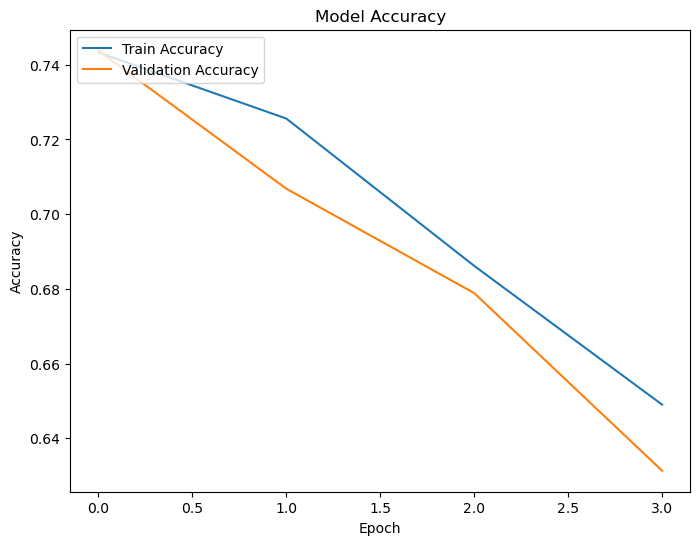

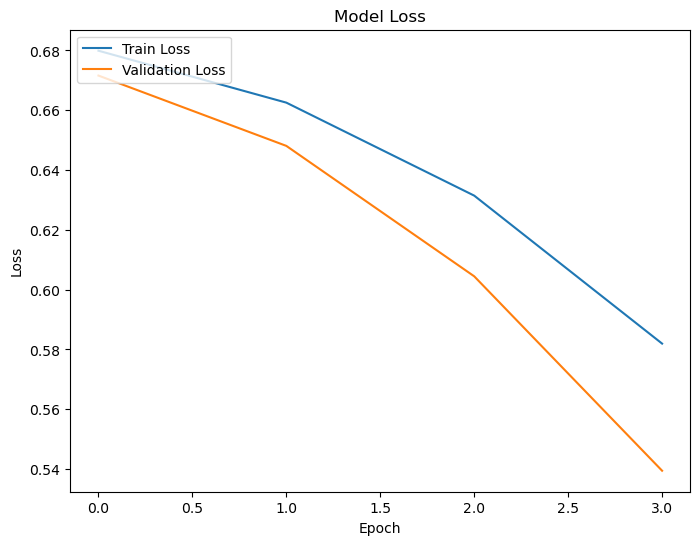

In [109]:
# Menampilkan grafik akurasi selama training
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Menampilkan grafik loss selama training
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

# Confusion Matrix

Confusion matrix digunakan untuk mengevaluasi performa klasifikasi model dengan menampilkan jumlah prediksi yang benar dan salah pada masing-masing kelas. Visualisasi heatmap memudahkan interpretasi hasil evaluasi.

195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step
Confusion matrix:
 [[   0    4 1289]
 [   0    1  303]
 [   0    0 4631]]


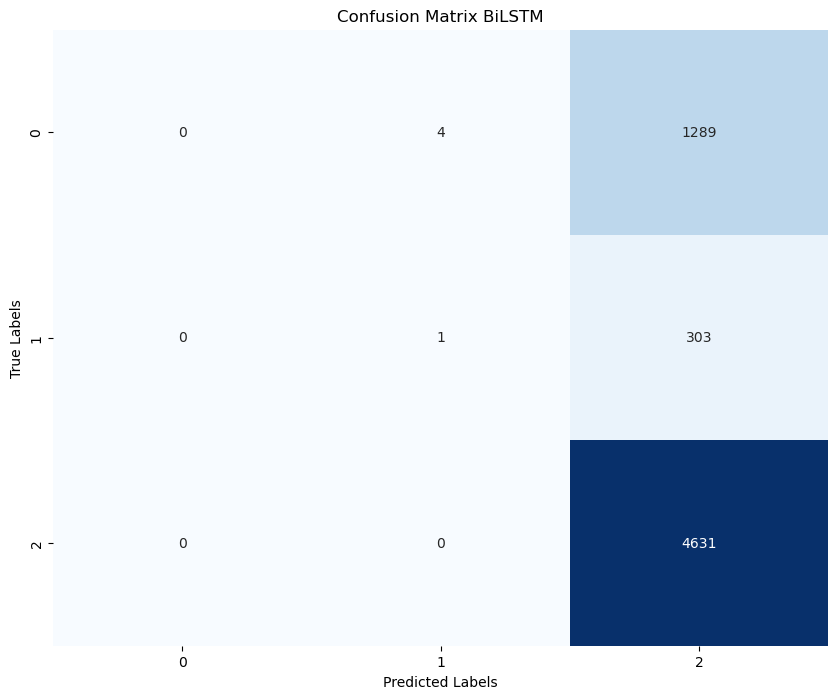

In [110]:
# Menghitung probabilitas prediksi model
model_pred_bilstm_prob = model_bilstm.predict(X_test)
# Mengkonversi probabilitas ke label (0 atau 1)
model_pred_bilstm = (model_pred_bilstm_prob > 0.5).astype("int32")

# Membuat confusion matrix
matrik_bilstm = confusion_matrix(y_test, model_pred_bilstm)
print('Confusion matrix:\n', matrik_bilstm)

# Visualisasi confusion matrix menggunakan heatmap dari seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(matrik_bilstm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix BiLSTM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

##

# TF-IDF

Di bagian ini, kita menghitung representasi numerik dari teks menggunakan TF-IDF. TF (Term Frequency) mengukur frekuensi kata dalam dokumen, sedangkan IDF (Inverse Document Frequency) mengukur seberapa umum atau jarangnya sebuah kata muncul di antara seluruh dokumen.

Proses ini mengubah teks menjadi representasi numerik menggunakan TF-IDF. Perhitungan IDF dilakukan dengan rumus logaritma, dan untuk setiap dokumen, kolom TF ditambahkan ke DataFrame agar dapat dianalisis lebih lanjut.

In [111]:
# Inisialisasi dan Fit TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import numpy as np
import pandas as pd

# Inisialisasi TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Melakukan fit_transform pada kolom text_String dengan progress bar
tfidf_matrix = tfidf_vectorizer.fit_transform(tqdm(df['text_String'], desc="Menghitung TF-IDF"))

# Mengambil daftar fitur (kata-kata)
terms = tfidf_vectorizer.get_feature_names_out()

# Menghitung IDF secara manual: log(N / (df + 1)), di mana N adalah jumlah dokumen
idf = np.log(tfidf_matrix.shape[0] / (np.count_nonzero(tfidf_matrix.toarray(), axis=0) + 1))

# Membuat DataFrame untuk menyimpan term dan IDF
tfidf_df = pd.DataFrame({'term': terms, 'idf': idf})

# Menambahkan kolom TF (term frequency) untuk setiap dokumen
for i, doc in enumerate(tqdm(df['text_String'], desc="Menambahkan kolom TF")):
    tf = tfidf_matrix[i].toarray().flatten()
    tfidf_df[f'tf_{i}'] = tf

# Tampilkan beberapa baris DataFrame TF-IDF
tfidf_df.head()

Menambahkan kolom TF: 100%|██████████| 31139/31139 [05:33<00:00, 93.35it/s] 


,term,idf,tf_0,tf_1,tf_2,tf_3,tf_4,tf_5,tf_6,tf_7,...,tf_31129,tf_31130,tf_31131,tf_31132,tf_31133,tf_31134,tf_31135,tf_31136,tf_31137,tf_31138
0,aaaa,9.653069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aaaarrrggghhh,9.653069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aaal,9.653069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aaii,9.653069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aaman,9.653069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Menampilkan Hasil TF-IDF

In [112]:
# Menampilkan DataFrame TF-IDF yang berisi term, IDF, dan TF untuk masing-masing dokumen
tfidf_df

,term,idf,tf_0,tf_1,tf_2,tf_3,tf_4,tf_5,tf_6,tf_7,...,tf_31129,tf_31130,tf_31131,tf_31132,tf_31133,tf_31134,tf_31135,tf_31136,tf_31137,tf_31138
0,aaaa,9.653069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aaaarrrggghhh,9.653069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aaal,9.653069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aaii,9.653069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aaman,9.653069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055,zonk,8.266775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9056,zoom,9.247604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9057,zooos,9.653069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9058,zulfian,9.653069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Menyimpan TfidfVectorizer

In [114]:
from joblib import dump

# Simpan objek TfidfVectorizer yang telah di-fit agar dapat digunakan kembali nanti
dump(tfidf_vectorizer, r'D:\PROJECT\Proyek Analisis Sentimen\Tests\tfidf_vectorizer.joblib')
print("TfidfVectorizer telah disimpan sebagai 'tfidf_vectorizer.joblib'")

TfidfVectorizer telah disimpan sebagai 'tfidf_vectorizer.joblib'


# Mengakses Vocabulary

Vocabulary berisi mapping dari kata ke indeks, yang digunakan oleh TfidfVectorizer untuk membangun representasi numerik dari teks.

In [115]:
# Mengakses vocabulary dari TfidfVectorizer
vocab = tfidf_vectorizer.vocabulary_

# Menampilkan vocabulary secara keseluruhan
print(vocab)

# Menampilkan 10 entri pertama dari vocabulary
for word, index in list(vocab.items())[:10]:
    print(f'Kata: {word}, Indeks: {index}')


{'heran': 2936, 'brimo': 1289, 'telepon': 8011, 'aktif': 174, 'pasang': 5977, 'login': 4253, 'nomor': 5600, 'sesuai': 7392, 'maksudny': 4410, 'coba': 1621, 'daftar': 1729, 'update': 8708, 'ikut': 3051, 'perintah': 6210, 'aplikasi': 472, 'mulu': 5259, 'tolong': 8313, 'baik': 711, 'kayak': 3552, 'video': 8829, 'viralkan': 8834, 'kelas': 3621, 'bank': 780, 'nasional': 5363, 'banget': 756, 'buka': 1389, 'mohon': 5151, 'cerah': 1559, 'good': 2729, 'pakai': 5907, 'selesai': 7264, 'masuk': 4671, 'rumit': 6932, 'layan': 4120, 'ribet': 6848, 'ramah': 6652, 'alhamdulillah': 242, 'maju': 4376, 'moga': 5149, 'depa': 1848, 'mudah': 5233, 'transaksi': 8384, 'lancar': 4069, 'lumayan': 4316, 'nyaman': 5681, 'bantu': 797, 'apded': 435, 'error': 2320, 'sinyal': 7524, 'kuat': 3972, 'stabil': 7694, 'pengaruh': 6122, 'cuaca': 1689, 'biar': 1078, 'cepat': 1547, 'sidik': 7462, 'jari': 3252, 'transfer': 8400, 'gagal': 2531, 'aris': 551, 'lelet': 4154, 'kitu': 3792, 'lapor': 4104, 'urang': 8749, 'sumedang': 77

In [116]:
vocab

{'heran': 2936,
 'brimo': 1289,
 'telepon': 8011,
 'aktif': 174,
 'pasang': 5977,
 'login': 4253,
 'nomor': 5600,
 'sesuai': 7392,
 'maksudny': 4410,
 'coba': 1621,
 'daftar': 1729,
 'update': 8708,
 'ikut': 3051,
 'perintah': 6210,
 'aplikasi': 472,
 'mulu': 5259,
 'tolong': 8313,
 'baik': 711,
 'kayak': 3552,
 'video': 8829,
 'viralkan': 8834,
 'kelas': 3621,
 'bank': 780,
 'nasional': 5363,
 'banget': 756,
 'buka': 1389,
 'mohon': 5151,
 'cerah': 1559,
 'good': 2729,
 'pakai': 5907,
 'selesai': 7264,
 'masuk': 4671,
 'rumit': 6932,
 'layan': 4120,
 'ribet': 6848,
 'ramah': 6652,
 'alhamdulillah': 242,
 'maju': 4376,
 'moga': 5149,
 'depa': 1848,
 'mudah': 5233,
 'transaksi': 8384,
 'lancar': 4069,
 'lumayan': 4316,
 'nyaman': 5681,
 'bantu': 797,
 'apded': 435,
 'error': 2320,
 'sinyal': 7524,
 'kuat': 3972,
 'stabil': 7694,
 'pengaruh': 6122,
 'cuaca': 1689,
 'biar': 1078,
 'cepat': 1547,
 'sidik': 7462,
 'jari': 3252,
 'transfer': 8400,
 'gagal': 2531,
 'aris': 551,
 'lelet': 4154

In [117]:
# Menampilkan beberapa entri pertama dari kosakata
for word, index in list(vocab.items())[:10]:
    print(f'Kata: {word}, Indeks: {index}')

Kata: heran, Indeks: 2936
Kata: brimo, Indeks: 1289
Kata: telepon, Indeks: 8011
Kata: aktif, Indeks: 174
Kata: pasang, Indeks: 5977
Kata: login, Indeks: 4253
Kata: nomor, Indeks: 5600
Kata: sesuai, Indeks: 7392
Kata: maksudny, Indeks: 4410
Kata: coba, Indeks: 1621


# Mengubah Teks Menjadi Representasi Numerik dan Mengatasi Imbalanced Data

Representasi numerik teks dihasilkan ulang dan SMOTE diterapkan untuk menangani ketidakseimbangan kelas, sehingga dataset menjadi lebih seimbang untuk pelatihan model.

In [118]:
# Menggunakan TfidfVectorizer untuk mengubah teks menjadi representasi numerik
# Pastikan tidak ada nilai NaN pada X
X = df['text_String'].fillna('')
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Menggunakan SMOTE untuk menangani masalah imbalanced data
from imblearn.over_sampling import SMOTE
smote = SMOTE()

X_sm, y_sm = smote.fit_resample(X_tfidf, y)

# Tampilkan bentuk data setelah resampling
print("Bentuk X_sm:", X_sm.shape)
print("Bentuk y_sm:", y_sm.shape)


Bentuk X_sm: (69594, 9060)
Bentuk y_sm: (69594,)


In [119]:
# print isi semua data
print(X_sm)

  (0, 1729)	0.21735289559184306
  (0, 1621)	0.2504340026097084
  (0, 4410)	0.5050482455650558
  (0, 7392)	0.26032880005366743
  (0, 5600)	0.25912172753235274
  (0, 4253)	0.19542870794055614
  (0, 5977)	0.3479274423805065
  (0, 174)	0.2626962393578628
  (0, 8011)	0.357440952123823
  (0, 1289)	0.1179805284165758
  (0, 2936)	0.36071180516790535
  (1, 756)	0.15276791556707803
  (1, 5363)	0.37316064675793953
  (1, 780)	0.17010405768923123
  (1, 3621)	0.30201852518579936
  (1, 8834)	0.4082772427897958
  (1, 8829)	0.3365409274356533
  (1, 3552)	0.2198604232721128
  (1, 711)	0.16823418776054444
  (1, 8313)	0.1627669233887299
  (1, 5259)	0.21586464807317918
  (1, 472)	0.22887092664268133
  (1, 6210)	0.29750452200027
  (1, 3051)	0.2659555914129363
  (1, 8708)	0.27560339130846295
  :	:
  (69589, 5854)	0.13155058902498587
  (69589, 6997)	0.09863209496239347
  (69589, 3729)	0.17770316048675225
  (69589, 5897)	0.16523836819857773
  (69590, 2531)	0.03482874888553236
  (69590, 3459)	0.0339020330073888

# Split Dataset

Data yang telah direpresentasikan secara numerik dan di-resample dibagi menjadi training dan testing set. Pembagian ini penting agar model dapat dievaluasi pada data yang belum pernah dilihat sebelumnya.

In [120]:
from sklearn.model_selection import train_test_split

# Membagi dataset hasil resampling menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=40)

print(f"Jumlah X_train: {X_train.shape[0]}")
print(f"Jumlah X_test: {X_test.shape[0]}")
print(f"Jumlah y_train: {y_train.shape[0]}")
print(f"Jumlah y_test: {y_test.shape[0]}")

Jumlah X_train: 55675
Jumlah X_test: 13919
Jumlah y_train: 55675
Jumlah y_test: 13919


##

# Random Forest Classifier

Model Random Forest digunakan untuk melakukan klasifikasi sentimen. Model dilatih menggunakan data latih, dan hasil training ditampilkan untuk verifikasi.

In [121]:
from sklearn.ensemble import RandomForestClassifier

# Inisialisasi dan latih model Random Forest
algorithm = RandomForestClassifier()
model = algorithm.fit(X_train, y_train)

# Tampilkan model RandomForestClassifier
print(model)

RandomForestClassifier()


In [122]:
RandomForestClassifier()

RandomForestClassifier()

# Menyimpan Model Random Forest

In [123]:
from joblib import dump

# Simpan model yang telah dilatih ke file dengan joblib
dump(model, filename=r'D:\PROJECT\Proyek Analisis Sentimen\Tests\model_rf.joblib')
print("Model Random Forest telah disimpan sebagai 'model_rf.joblib'")

Model Random Forest telah disimpan sebagai 'model_rf.joblib'


# Prediksi dan Evaluasi Model Random Forest

Model yang telah dilatih digunakan untuk memprediksi label pada data uji. Evaluasi dilakukan dengan menghitung jumlah prediksi benar dan salah serta menghitung akurasi pengujian.

In [124]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Menggunakan model untuk memprediksi label pada data uji
model_pred = model.predict(X_test)

# Tampilkan hasil prediksi dan label sebenarnya
print("Hasil Prediksi Model:")
print(model_pred[:10])
print("\nLabel Sebenarnya:")
print(y_test[:10])

# Hitung jumlah prediksi benar dan salah
prediksi_benar = (model_pred == y_test).sum()
prediksi_salah = (model_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

# Hitung akurasi pengujian
accuracy_rf = prediksi_benar / (prediksi_benar + prediksi_salah) * 100
print('Akurasi pengujian\t:', accuracy_rf, '%')

Hasil Prediksi Model:
[ 1 -1 -1 -1 -1  0 -1 -1  0  0]

Label Sebenarnya:
12180    1
39737   -1
6409    -1
12687   -1
40847   -1
63485    0
43364   -1
1072     1
57470    0
56466    0
Name: label_num, dtype: int64
Jumlah prediksi benar	: 12814
Jumlah prediksi salah	: 1105
Akurasi pengujian	: 92.0612112939148 %


In [125]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model_pred = model.predict(X_test)

# Tampilkan hasil prediksi label dari model
model_pred

array([ 1, -1, -1, ...,  0,  1,  1], dtype=int64)

In [126]:
# Tampilkan label sebenarnya pada data uji (actual label)
y_test

12180    1
39737   -1
6409    -1
12687   -1
40847   -1
        ..
30994    1
8223     1
68502    0
23974    1
51791    0
Name: label_num, Length: 13919, dtype: int64

In [127]:
# Hitung jumlah data yang berhasil di prediksi model & jumlah data yang salah di prediksi
prediksi_benar = (model_pred == y_test).sum()
prediksi_salah = (model_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy_rf = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy_rf, '%')

Jumlah prediksi benar	: 12814
Jumlah prediksi salah	: 1105
Akurasi pengujian	: 92.0612112939148 %


# Confusion Matrix

Confusion matrix memberikan gambaran jumlah prediksi yang benar dan salah pada masing-masing kelas. Visualisasi heatmap memudahkan interpretasi hasil evaluasi model.

Confusion matrix:
 [[4388  118  128]
 [ 171 4476   87]
 [ 477  124 3950]]


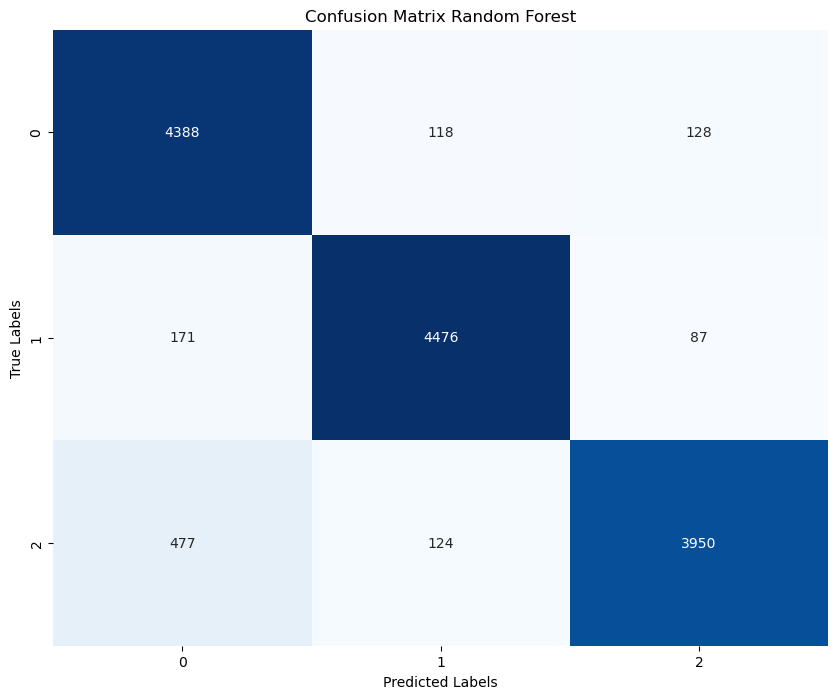

In [128]:
# Membuat confusion matrix
matrik = confusion_matrix(y_test, model_pred)
print('Confusion matrix:\n', matrik)

# Visualisasi confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrik, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Classification Report

Classification report menyajikan metrik evaluasi seperti precision, recall, dan F1-score untuk masing-masing kelas, sehingga memberikan gambaran performa model secara lebih rinci.

In [130]:
# Menampilkan classification report untuk evaluasi detail performa model
print('Classification report:\n', classification_report(y_test, model_pred))

Classification report:
               precision    recall  f1-score   support

          -1       0.87      0.95      0.91      4634
           0       0.95      0.95      0.95      4734
           1       0.95      0.87      0.91      4551

    accuracy                           0.92     13919
   macro avg       0.92      0.92      0.92     13919
weighted avg       0.92      0.92      0.92     13919



# Random Forest dengan Fitur TF-IDF

In [133]:
# random forest dengan pembagian data 85% training dan 15% testing
X_train , X_test , y_train , y_test = train_test_split(X_sm , y_sm , test_size=0.15,random_state=2)

print(f"Jumlah X_train: {X_train.shape[0]}")
print(f"Jumlah X_test: {X_test.shape[0]}")
print(f"Jumlah y_train: {y_train.shape[0]}")
print(f"Jumlah y_test: {y_test.shape[0]}")

algorithm = RandomForestClassifier()
model = algorithm.fit(X_train, y_train)   # Fitkan (latih) algoritma pada data latih & label latih

RandomForestClassifier()

from joblib import dump # Digunakan untuk menyimpan model yang telah dilatih

# Simpan model hasil traning
dump(model, filename='model_rf1.joblib')

# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model_pred = model.predict(X_test)

# Tampilkan hasil prediksi label dari model
model_pred

# Tampilkan label sebenarnya pada data uji (actual label)
y_test

# Hitung jumlah data yang berhasil di prediksi model & jumlah data yang salah di prediksi
prediksi_benar = (model_pred == y_test).sum()
prediksi_salah = (model_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy_rf1 = prediksi_benar / (prediksi_benar + prediksi_salah)*100
accuracy_rf1 = round(accuracy_rf1, 0)
print('Akurasi pengujian\t:', accuracy_rf1, '%')




Jumlah X_train: 59154
Jumlah X_test: 10440
Jumlah y_train: 59154
Jumlah y_test: 10440
Jumlah prediksi benar	: 9620
Jumlah prediksi salah	: 820
Akurasi pengujian	: 92.0 %


In [134]:
# Pastikan kolom 'text_String' tidak memiliki nilai NaN dan simpan ke dalam variabel X_text
X_text = df['text_String'].fillna('')

In [135]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

tfidf_vectorizer_exp3 = TfidfVectorizer()
X_tfidf_exp3 = tfidf_vectorizer_exp3.fit_transform(tqdm(X_text, desc="TF-IDF Exp3"))


TF-IDF Exp3: 100%|██████████| 31139/31139 [00:00<00:00, 160334.54it/s]


# Random Forest dengan Fitur TF-IDF (Split 70/30)

Pada percobaan ketiga, fitur TF-IDF kembali digunakan namun dengan pembagian data 70% untuk pelatihan dan 30% untuk pengujian. Model Random Forest dilatih pada data ini dan dievaluasi dengan metrik evaluasi standar.

In [136]:
# Gunakan kembali TF-IDF untuk fitur (dapat menggunakan objek yang berbeda untuk menghindari kebingungan)
tfidf_vectorizer_exp3 = TfidfVectorizer()
X_tfidf_exp3 = tfidf_vectorizer_exp3.fit_transform(tqdm(X_text, desc="TF-IDF Exp3"))

# Pembagian data 70% training dan 30% testing (70/30)
X_train_exp3, X_test_exp3, y_train_exp3, y_test_exp3 = train_test_split(
    X_tfidf_exp3, y, test_size=0.3, random_state=40
)

# Inisialisasi dan latih model Random Forest
rf_model_tfidf = RandomForestClassifier(random_state=42)
rf_model_tfidf.fit(X_train_exp3, y_train_exp3)

# Evaluasi model Random Forest dengan TF-IDF
y_pred_exp3 = rf_model_tfidf.predict(X_test_exp3)
print("=== Random Forest (TF-IDF, 70/30) ===")
print("Accuracy:", accuracy_score(y_test_exp3, y_pred_exp3) * 100)
print("Confusion Matrix:\n", confusion_matrix(y_test_exp3, y_pred_exp3))
print("Classification Report:\n", classification_report(y_test_exp3, y_pred_exp3))


TF-IDF Exp3: 100%|██████████| 31139/31139 [00:00<00:00, 143258.13it/s]


=== Random Forest (TF-IDF, 70/30) ===
Accuracy: 83.44037679297794
Confusion Matrix:
 [[1433    7  483]
 [ 296    4  173]
 [ 575   13 6358]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.62      0.75      0.68      1923
           0       0.17      0.01      0.02       473
           1       0.91      0.92      0.91      6946

    accuracy                           0.83      9342
   macro avg       0.57      0.56      0.54      9342
weighted avg       0.81      0.83      0.82      9342



# Random Forest dengan Fitur Word2Vec (Split 80/20)

Eksperimen kedua menggunakan ekstraksi fitur Word2Vec. Token dari kolom text_Tokenization diubah menjadi vektor rata-rata menggunakan Word2Vec, kemudian data dibagi (80/20) dan model Random Forest dilatih dan dievaluasi.

In [150]:
# Pastikan tokenisasi teks sudah dilakukan dan tersimpan di kolom 'text_Tokenization'
tokenized_texts = df['text_Tokenization']

# Latih model Word2Vec pada tokenisasi teks
from gensim.models import Word2Vec
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4, seed=42)

# Fungsi untuk mendapatkan representasi dokumen sebagai rata-rata vektor kata
import numpy as np
def get_w2v_features(tokens, model, vector_size=100):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Ekstraksi fitur dokumen menggunakan Word2Vec
X_w2v = np.array([get_w2v_features(tokens, w2v_model) for tokens in tqdm(tokenized_texts, desc="Word2Vec Features")])

# Pembagian data 80/20
X_train_exp2, X_test_exp2, y_train_exp2, y_test_exp2 = train_test_split(
    X_w2v, y, test_size=0.2, random_state=40
)

# Pelatihan model Random Forest dengan fitur Word2Vec
from sklearn.ensemble import RandomForestClassifier
model_rf_w2v = RandomForestClassifier(random_state=42)
model_rf_w2v.fit(X_train_exp2, y_train_exp2)

# Evaluasi model Random Forest (Word2Vec)
model_pred_rf_w2v = model_rf_w2v.predict(X_test_exp2)
accuracy_rf_w2v = accuracy_score(y_test_exp2, model_pred_rf_w2v) * 100
print("Akurasi RF (Word2Vec, 80/20):", accuracy_rf_w2v, "%")
print("Confusion Matrix RF (Word2Vec):\n", confusion_matrix(y_test_exp2, model_pred_rf_w2v))
print("Classification Report RF (Word2Vec):\n", classification_report(y_test_exp2, model_pred_rf_w2v))


Word2Vec Features: 100%|██████████| 31139/31139 [00:05<00:00, 6187.18it/s]


Akurasi RF (Word2Vec, 80/20): 79.03018625561978 %
Confusion Matrix RF (Word2Vec):
 [[ 608    5  680]
 [ 125    1  178]
 [ 313    5 4313]]
Classification Report RF (Word2Vec):
               precision    recall  f1-score   support

          -1       0.58      0.47      0.52      1293
           0       0.09      0.00      0.01       304
           1       0.83      0.93      0.88      4631

    accuracy                           0.79      6228
   macro avg       0.50      0.47      0.47      6228
weighted avg       0.75      0.79      0.76      6228



# Random Forest dengan Fitur TF-IDF (Split 70/30)

Pada eksperimen ketiga, fitur TF-IDF digunakan kembali, namun data dibagi dengan rasio 70/30. Model Random Forest dilatih dan dievaluasi untuk mengetahui pengaruh pembagian data yang berbeda terhadap performa.

In [151]:
# Menggunakan kembali TF-IDF untuk fitur, kali ini dengan pembagian data 70/30
tfidf_vectorizer_exp3 = TfidfVectorizer()
X_tfidf_exp3 = tfidf_vectorizer_exp3.fit_transform(tqdm(X_text, desc="TF-IDF Exp3"))

# Pembagian data 70% training dan 30% testing
X_train_exp3, X_test_exp3, y_train_exp3, y_test_exp3 = train_test_split(
    X_tfidf_exp3, y, test_size=0.3, random_state=40
)

# Pelatihan model Random Forest dengan TF-IDF
model_rf_tfidf = RandomForestClassifier(random_state=42)
model_rf_tfidf.fit(X_train_exp3, y_train_exp3)

# Evaluasi model Random Forest (TF-IDF)
model_pred_rf_tfidf = model_rf_tfidf.predict(X_test_exp3)
accuracy_rf_tfidf = accuracy_score(y_test_exp3, model_pred_rf_tfidf) * 100
print("Akurasi RF (TF-IDF, 70/30):", accuracy_rf_tfidf, "%")
print("Confusion Matrix RF (TF-IDF):\n", confusion_matrix(y_test_exp3, model_pred_rf_tfidf))
print("Classification Report RF (TF-IDF):\n", classification_report(y_test_exp3, model_pred_rf_tfidf))


TF-IDF Exp3: 100%|██████████| 31139/31139 [00:00<00:00, 125117.29it/s]


Akurasi RF (TF-IDF, 70/30): 83.44037679297794 %
Confusion Matrix RF (TF-IDF):
 [[1433    7  483]
 [ 296    4  173]
 [ 575   13 6358]]
Classification Report RF (TF-IDF):
               precision    recall  f1-score   support

          -1       0.62      0.75      0.68      1923
           0       0.17      0.01      0.02       473
           1       0.91      0.92      0.91      6946

    accuracy                           0.83      9342
   macro avg       0.57      0.56      0.54      9342
weighted avg       0.81      0.83      0.82      9342



##

# SVM

# SVM dengan Fitur TF-IDF (Split 80/20)

Pada bagian ini, kita melatih model SVM menggunakan fitur TF-IDF. Data teks yang sudah bersih diubah menjadi representasi TF-IDF, kemudian dibagi dengan rasio 80/20. Model SVM dilatih dengan kernel linear dan disimpan menggunakan joblib.

In [154]:
# Persiapan Data (Pastikan kolom 'text_String' bersih)
X_text = df['text_String'].fillna('')

# Ekstraksi fitur dengan TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
tfidf_vectorizer_exp1 = TfidfVectorizer()
X_tfidf_exp1 = tfidf_vectorizer_exp1.fit_transform(tqdm(X_text, desc="TF-IDF Exp1"))

# Pembagian data dengan rasio 80/20
from sklearn.model_selection import train_test_split
X_train_exp1, X_test_exp1, y_train_exp1, y_test_exp1 = train_test_split(
    X_tfidf_exp1, y, test_size=0.2, random_state=40
)

# Pelatihan model SVM
from sklearn.svm import SVC
from joblib import dump
model_svm = SVC(kernel='linear', probability=True)
model_svm.fit(X_train_exp1, y_train_exp1)

# Simpan model SVM
dump(model_svm, filename='model_svm.joblib')
print("Model SVM telah disimpan sebagai 'model_svm.joblib'")

# Evaluasi model SVM
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
model_pred_svm = model_svm.predict(X_test_exp1)
accuracy_svm_ex1 = accuracy_score(y_test_exp1, model_pred_svm) * 100
print("Akurasi SVM (TF-IDF, 80/20):", accuracy_svm_ex1, "%")
print("Confusion Matrix SVM:\n", confusion_matrix(y_test_exp1, model_pred_svm))
print("Classification Report SVM:\n", classification_report(y_test_exp1, model_pred_svm))


TF-IDF Exp1:   0%|          | 0/31139 [00:00<?, ?it/s]

TF-IDF Exp1: 100%|██████████| 31139/31139 [00:00<00:00, 93700.25it/s] 


Model SVM telah disimpan sebagai 'model_svm.joblib'
Akurasi SVM (TF-IDF, 80/20): 84.50545921644188 %
Confusion Matrix SVM:
 [[ 952    2  339]
 [ 170    0  134]
 [ 320    0 4311]]
Classification Report SVM:
               precision    recall  f1-score   support

          -1       0.66      0.74      0.70      1293
           0       0.00      0.00      0.00       304
           1       0.90      0.93      0.92      4631

    accuracy                           0.85      6228
   macro avg       0.52      0.56      0.54      6228
weighted avg       0.81      0.85      0.83      6228



In [138]:
# menggunakan SVM
from sklearn.svm import SVC

# Inisialisasi model
model_svm = SVC()

# Latih model
model_svm.fit(X_train, y_train)

# Simpan model
dump(model_svm, filename=r'D:\PROJECT\Proyek Analisis Sentimen\Tests\model_svm.joblib')

['D:\\PROJECT\\Proyek Analisis Sentimen\\Tests\\model_svm.joblib']

# Prediksi dan Evaluasi Model SVM

Kode di atas melakukan prediksi pada data uji menggunakan model SVM yang telah dilatih, kemudian menghitung jumlah prediksi yang benar dan salah serta menghitung akurasi pengujian.

In [143]:
# Menggunakan model SVM untuk memprediksi label pada data uji
model_pred_svm = model_svm.predict(X_test)

# Tampilkan hasil prediksi
print("Hasil Prediksi SVM (contoh):", model_pred_svm[:10])

# Hitung jumlah prediksi benar dan salah
prediksi_benar_svm = (model_pred_svm == y_test).sum()
prediksi_salah_svm = (model_pred_svm != y_test).sum()
print('Jumlah prediksi benar\t:', prediksi_benar_svm)
print('Jumlah prediksi salah\t:', prediksi_salah_svm)

# Hitung akurasi
accuracy_svm = accuracy_score(y_test, model_pred_svm) * 100
print('Akurasi pengujian\t:', accuracy_svm, '%')

Hasil Prediksi SVM (contoh): [-1  1  1 -1  1  1  1  1  1  1]
Jumlah prediksi benar	: 5263
Jumlah prediksi salah	: 965
Akurasi pengujian	: 84.50545921644188 %


# Visualisasi Evaluasi Model SVM

Visualisasi confusion matrix dan classification report membantu dalam memahami performa model SVM secara detail, dengan menunjukkan metrik seperti precision, recall, dan F1-score pada masing-masing kelas.

Confusion matrix:
 [[ 952    2  339]
 [ 170    0  134]
 [ 320    0 4311]]


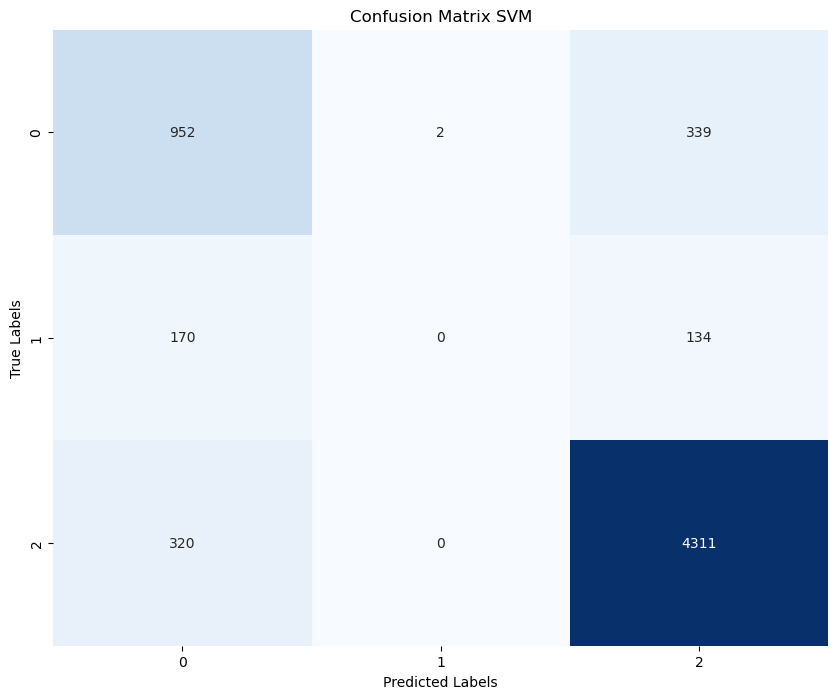

Classification report:
               precision    recall  f1-score   support

          -1       0.66      0.74      0.70      1293
           0       0.00      0.00      0.00       304
           1       0.90      0.93      0.92      4631

    accuracy                           0.85      6228
   macro avg       0.52      0.56      0.54      6228
weighted avg       0.81      0.85      0.83      6228



In [144]:
# Confusion Matrix SVM
matrik_svm = confusion_matrix(y_test, model_pred_svm)
print('Confusion matrix:\n', matrik_svm)

# Plot confusion matrix dengan seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrik_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report SVM
print('Classification report:\n', classification_report(y_test, model_pred_svm))

##

# Decision Tree

# Decision Tree Classifier (TF-IDF, Split 80/20)

Pada bagian ini, model Decision Tree dilatih menggunakan fitur TF-IDF dengan pembagian data 80/20 yang sama dengan model SVM. Setelah dilatih, model dievaluasi dengan menghitung akurasi dan jumlah prediksi benar/salah.

In [145]:
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# Inisialisasi model Decision Tree
model_dt = DecisionTreeClassifier()

# Latih model Decision Tree pada data yang sama (TF-IDF, split 80/20)
model_dt.fit(X_train, y_train)

# Simpan model Decision Tree
dump(model_dt, filename=r'D:\PROJECT\Proyek Analisis Sentimen\Tests\model_dt.joblib')
print("Model Decision Tree telah disimpan sebagai 'model_dt.joblib'")

# Prediksi dengan Decision Tree
model_pred_dt = model_dt.predict(X_test)

# Hitung jumlah prediksi benar dan salah untuk Decision Tree
prediksi_benar_dt = (model_pred_dt == y_test).sum()
prediksi_salah_dt = (model_pred_dt != y_test).sum()
print('Jumlah prediksi benar\t:', prediksi_benar_dt)
print('Jumlah prediksi salah\t:', prediksi_salah_dt)

accuracy_dt = accuracy_score(y_test, model_pred_dt) * 100
print('Akurasi pengujian\t:', accuracy_dt, '%')

Model Decision Tree telah disimpan sebagai 'model_dt.joblib'
Jumlah prediksi benar	: 5013
Jumlah prediksi salah	: 1215
Akurasi pengujian	: 80.49132947976878 %


# Visualisasi Evaluasi Model Decision Tree

Confusion matrix:
 [[ 791  102  400]
 [ 152   26  126]
 [ 369   66 4196]]


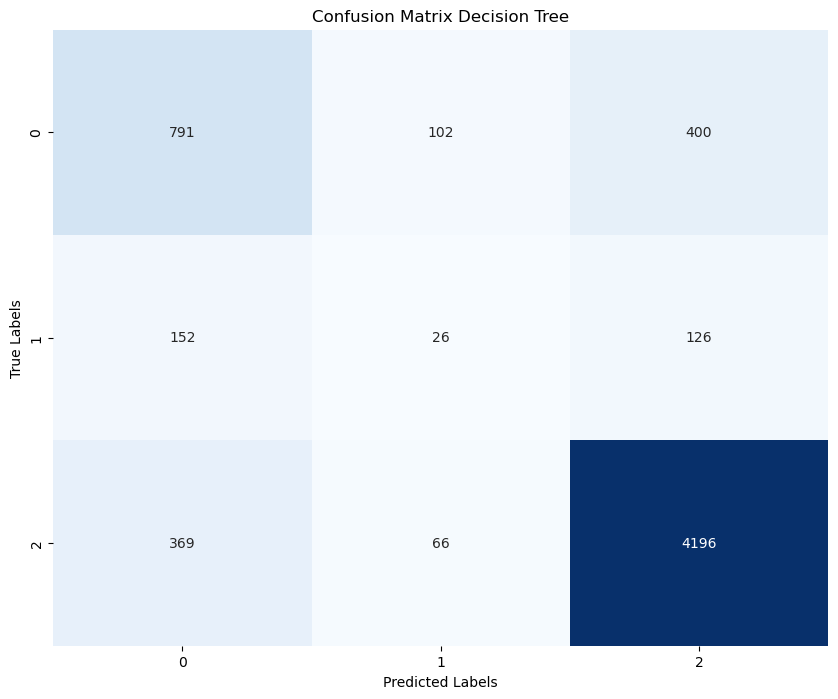

Classification report:
               precision    recall  f1-score   support

          -1       0.60      0.61      0.61      1293
           0       0.13      0.09      0.10       304
           1       0.89      0.91      0.90      4631

    accuracy                           0.80      6228
   macro avg       0.54      0.53      0.54      6228
weighted avg       0.79      0.80      0.80      6228



In [146]:
# Confusion Matrix untuk Decision Tree
matrik_dt = confusion_matrix(y_test, model_pred_dt)
print('Confusion matrix:\n', matrik_dt)

# Plot confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrik_dt, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Decision Tree')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report untuk Decision Tree
print('Classification report:\n', classification_report(y_test, model_pred_dt))


##

# PERBANDINGAN AKURASI MODEL

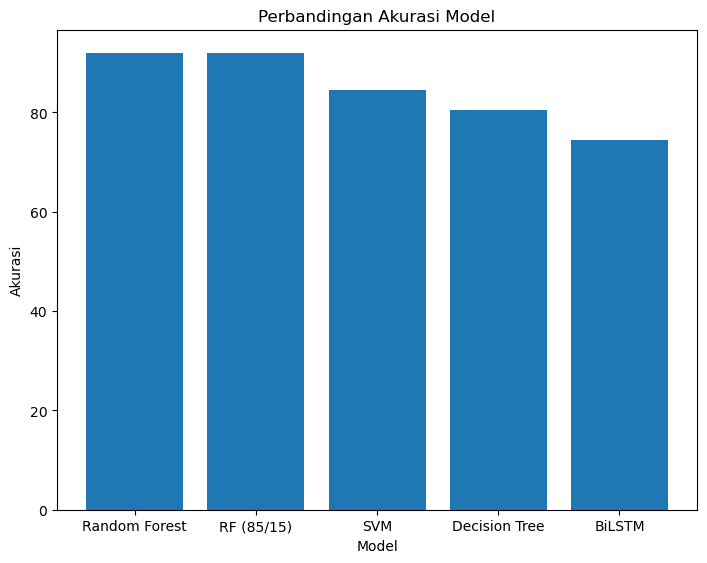

In [155]:
# grafik perbandingan akurasi
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
model = ['Random Forest', 'RF (85/15)', 'SVM', 'Decision Tree', 'BiLSTM']
accuracy = [accuracy_rf, accuracy_rf1, accuracy_svm, accuracy_dt, accuracy_bilstm]
ax.bar(model, accuracy)
plt.title('Perbandingan Akurasi Model')
plt.xlabel('Model')
plt.ylabel('Akurasi')
plt.show()

In [158]:
# print hasil akurasi dari masing-masing model dalam bentuk dataframe
df_accuracy = pd.DataFrame({'Model': ['Random Forest  (85/15)', 'Random Forest', 'SVM', 'Decision Tree', 'BiLSTM'],
                             'Accuracy': [accuracy_rf1, accuracy_rf, accuracy_svm, accuracy_dt, accuracy_bilstm]})
df_accuracy

,Model,Accuracy
0,Random Forest (85/15),92.000000
1,Random Forest,92.061211
2,SVM,84.505459
3,Decision Tree,80.491329
4,BiLSTM,74.373794


Grafik ini menyajikan perbandingan akurasi dari berbagai model yang telah dilatih (misalnya Random Forest dengan split 85/15 dan 80/20, SVM, Decision Tree, dan BiLSTM). Dengan visualisasi ini, Anda dapat dengan cepat melihat model mana yang memiliki performa terbaik.

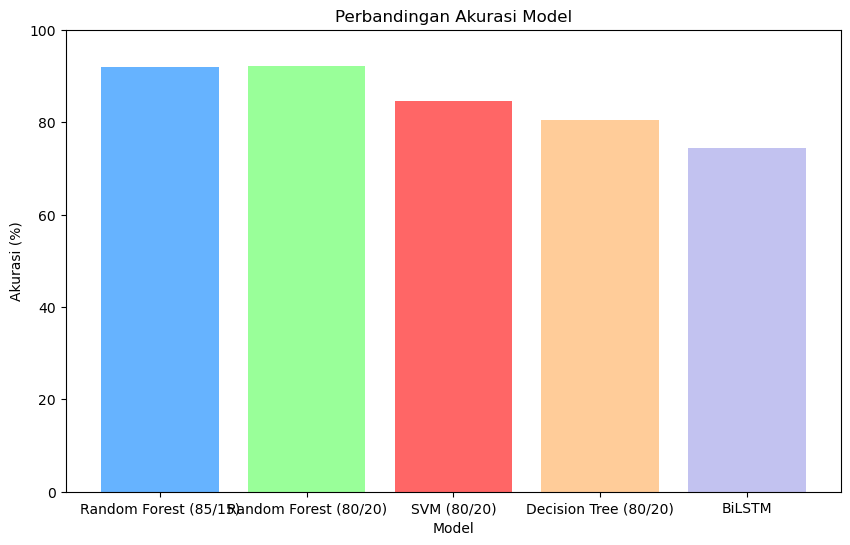

In [152]:
# Grafik perbandingan akurasi dari beberapa model
models = ['Random Forest (85/15)', 'Random Forest (80/20)', 'SVM (80/20)', 'Decision Tree (80/20)', 'BiLSTM']
# Pastikan variabel accuracy_rf, accuracy_rf1, accuracy_svm, accuracy_dt, accuracy_bilstm sudah didefinisikan dari eksperimen sebelumnya
accuracy_values = [accuracy_rf1, accuracy_rf, accuracy_svm, accuracy_dt, accuracy_bilstm]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracy_values, color=['#66b3ff', '#99ff99', '#ff6666', '#ffcc99', '#c2c2f0'])
plt.title('Perbandingan Akurasi Model')
plt.xlabel('Model')
plt.ylabel('Akurasi (%)')
plt.ylim(0, 100)
plt.show()


# Test Model
#### Melakukan inference atau testing yang menghasilkan output berupa kelas kategorikal (contoh: negatif, netral, dan positif)

Pada bagian Test Model, model dan vectorizer yang telah disimpan dimuat kembali. Input teks yang diberikan dipreprocessing terlebih dahulu, kemudian diubah menjadi fitur dengan TF-IDF sebelum dilakukan prediksi. Hasil prediksi berupa nilai numerik kemudian dipetakan ke label sentimen (Negatif, Netral, Positif).

In [42]:
from joblib import load
from sklearn.feature_extraction.text import TfidfVectorizer

# Muat model yang telah disimpan
model = load(r'D:\PROJECT\Proyek Analisis Sentimen\Model\model_rf.joblib')

# Muat TF-IDF Vectorizer yang telah disimpan
vectorizer = load(r'D:\PROJECT\Proyek Analisis Sentimen\Model\tfidf_vectorizer.joblib')

# Tetapkan input teks secara manual
test_input = "Brimo sangat membantu saya dalam melakukan transaksi"

# Preprocess text
test_input_preprocessed = preprocess_text(test_input)

# Tampilkan hasil preprocessing
print(f'Teks setelah preprocessing: {test_input_preprocessed}')

# Transformasi input teks yang telah dipreprocessing menjadi fitur
test_input_transformed = vectorizer.transform([test_input_preprocessed])

# Buat prediksi
prediksi = model.predict(test_input_transformed)

# Ambil hasil prediksi
hasil_prediksi = prediksi[0]

# Map hasil prediksi ke label sentimen menggunakan if-else
if hasil_prediksi == -1:
    sentimen = 'Negatif'
elif hasil_prediksi == 0:
    sentimen = 'Netral'
elif hasil_prediksi == 1:
    sentimen = 'Positif'
else:
    sentimen = 'Label tidak dikenali'

# Cetak hasil sentimen
print(f'Hasil prediksi: {sentimen}')


Teks setelah preprocessing: brimo sangat membantu saya dalam melakukan transaksi
Hasil prediksi: Positif


# Simpan Hasil Prediksi ke File

In [43]:
# Simpan hasil prediksi ke file teks
with open('hasil_prediksi.txt', 'w') as file:
    file.write(f'Teks asli: {test_input}\n')
    file.write(f'Teks setelah preprocessing: {test_input_preprocessed}\n')
    file.write(f'Hasil sentimen: {sentimen}\n')

##

# Install WordCloud
#### Teknik untuk melakukan visualisasi pada DataFrame

Instalasi WordCloud digunakan untuk memvisualisasikan kata-kata yang sering muncul dari masing-masing kelas sentimen.

In [99]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


##

# WordCloud for Positive Sentiment

WordCloud untuk sentimen positif dibuat tanpa menggunakan mask. Data teks yang telah diproses dari ulasan positif digabungkan dan divisualisasikan dengan latar belakang putih.

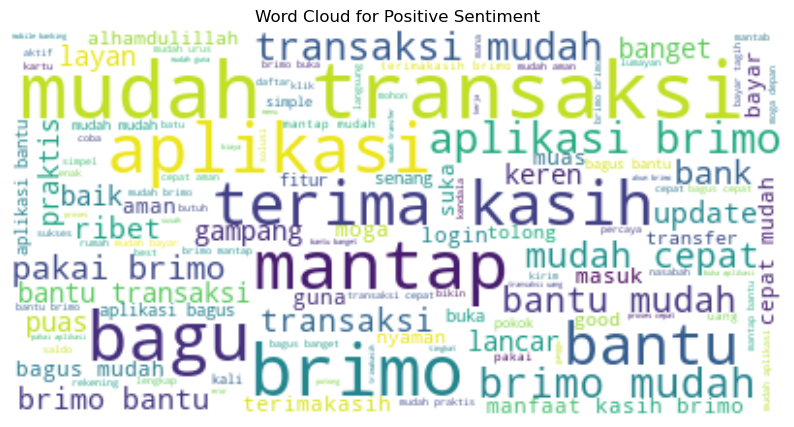

In [161]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter data untuk sentimen positif (label_num == 1)
df_positive = df[df['label_num'] == 1]

# Gabungkan semua kata dari kolom 'text_String'
all_words_positive = ' '.join(df_positive['text_String'])

# Buat dan tampilkan WordCloud tanpa mask (default)
wordcloud_positive = WordCloud(background_color='white', contour_width=1, contour_color='black').generate(all_words_positive)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')
plt.show()

##

# WordCloud for Neutral Sentiment

Visualisasi WordCloud untuk sentimen netral dibuat dengan menggabungkan teks dari ulasan netral dan menampilkan hasilnya tanpa mask.

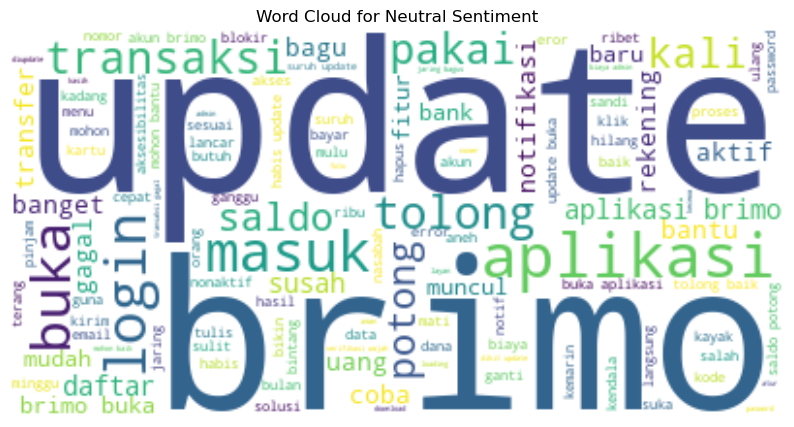

In [162]:
# Filter data untuk sentimen netral (label_num == 0)
df_neutral = df[df['label_num'] == 0]

# Gabungkan semua kata dari kolom 'text_String'
all_words_neutral = ' '.join(df_neutral['text_String'])

# Buat dan tampilkan WordCloud tanpa mask
wordcloud_neutral = WordCloud(background_color='white', contour_width=1, contour_color='black').generate(all_words_neutral)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Word Cloud for Neutral Sentiment')
plt.axis('off')
plt.show()


##

# WordCloud for Negative Sentiment

WordCloud untuk sentimen negatif dibuat dengan cara yang sama, dengan menggabungkan teks dari ulasan negatif dan menampilkan hasilnya tanpa menggunakan gambar mask.

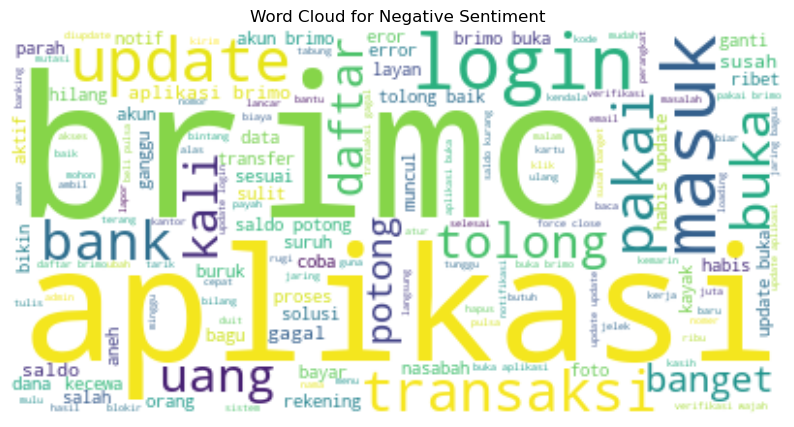

In [163]:
# Filter data untuk sentimen negatif (label_num == -1)
df_negative = df[df['label_num'] == -1]

# Gabungkan semua kata dari kolom 'text_String'
all_words_negative = ' '.join(df_negative['text_String'])

# Buat dan tampilkan WordCloud tanpa mask
wordcloud_negative = WordCloud(background_color='white', contour_width=1, contour_color='black').generate(all_words_negative)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')
plt.show()


##

# Words That Appear The Most

Bagian ini menghitung frekuensi kata dari ulasan (misalnya, pada sentimen negatif) dan menampilkan 10 kata paling sering muncul dalam bentuk grafik bar untuk memudahkan analisis.

[nltk_data] Downloading package punkt to C:\Users\Sion
[nltk_data]     Pardosi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


3 kata paling sering: [('brimo', 1880), ('aplikasi', 1643), ('update', 1459)]
   brimo aplikasi   update 
    1880     1643     1459 


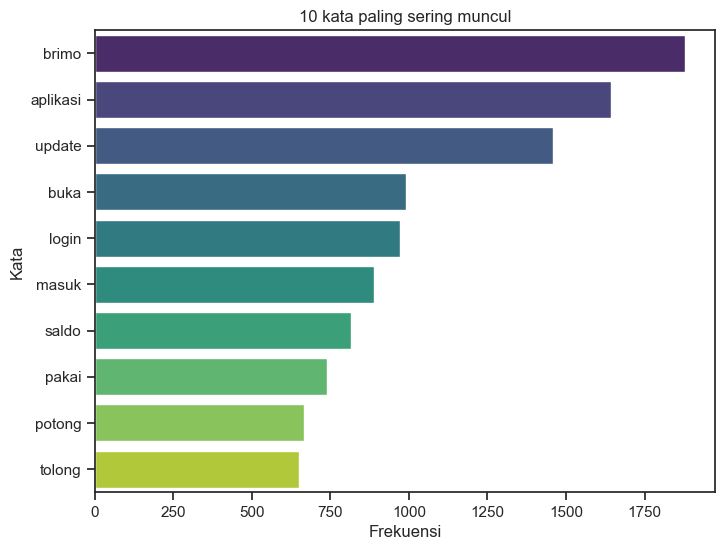

In [164]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import pandas as pd
import seaborn as sns

# Misalnya, gunakan semua kata dari WordCloud negatif sebagai contoh
words = word_tokenize(all_words_negative)
fd = FreqDist(words)

# Tampilkan 3 kata paling sering muncul
print("3 kata paling sering:", fd.most_common(3))
fd.tabulate(3)

# Ambil top 10 kata dan buat pandas Series untuk plotting
top_10 = fd.most_common(10)
fdist = pd.Series(dict(top_10))

sns.set_theme(style="ticks")
plt.figure(figsize=(8, 6))
plt.title('10 kata paling sering muncul')
sns.barplot(x=fdist.values, y=fdist.index, palette='viridis')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()
